Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 45.7MB/s]


Loaded 10000 images (['cat', 'dog'])
Training REG SiT...


REG Epoch 1: 100%|██████████| 39/39 [00:05<00:00,  6.53it/s]


REG Epoch 1 Avg Loss: 0.2745


REG Epoch 2: 100%|██████████| 39/39 [00:04<00:00,  9.38it/s]


REG Epoch 2 Avg Loss: -0.1602


REG Epoch 3: 100%|██████████| 39/39 [00:04<00:00,  8.48it/s]


REG Epoch 3 Avg Loss: -0.2522


REG Epoch 4: 100%|██████████| 39/39 [00:04<00:00,  9.39it/s]


REG Epoch 4 Avg Loss: -0.3036


REG Epoch 5: 100%|██████████| 39/39 [00:04<00:00,  9.18it/s]


REG Epoch 5 Avg Loss: -0.3338
Training U-Net...


UNet Epoch 1: 100%|██████████| 39/39 [00:03<00:00, 11.31it/s]


UNet Epoch 1 Avg Loss: 0.9115


UNet Epoch 2: 100%|██████████| 39/39 [00:02<00:00, 14.73it/s]


UNet Epoch 2 Avg Loss: 0.6266


UNet Epoch 3: 100%|██████████| 39/39 [00:02<00:00, 15.12it/s]


UNet Epoch 3 Avg Loss: 0.4258


UNet Epoch 4: 100%|██████████| 39/39 [00:02<00:00, 15.06it/s]


UNet Epoch 4 Avg Loss: 0.3631


UNet Epoch 5: 100%|██████████| 39/39 [00:03<00:00, 10.99it/s]


UNet Epoch 5 Avg Loss: 0.3222


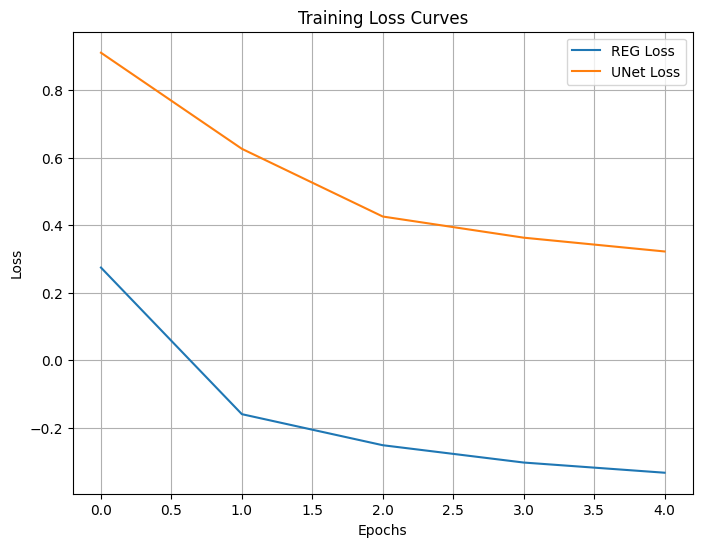

Evaluating Models on 1000 samples...


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 117MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "./outputs_sit_reg_fixed/reg_eval_1000" with extensions png,jpg,jpeg
Found 1000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dat

REG Evaluation Metrics: {'frechet_inception_distance': 514.3218825855131}


Frechet Inception Distance: 514.3218825855131


REG Representational Alignment (Cosine Sim): 0.7913


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "./outputs_sit_reg_fixed/unet_eval_1000" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "./outputs_sit_reg_fixed/real_images_1000" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples


UNET Evaluation Metrics: {'frechet_inception_distance': 505.51205294597327}


Frechet Inception Distance: 505.51205294597327


UNET Representational Alignment (Cosine Sim): 0.7881
Evaluation complete. Results: {'reg': {'frechet_inception_distance': 514.3218825855131, 'representational_alignment': 0.7913216948509216}, 'unet': {'frechet_inception_distance': 505.51205294597327, 'representational_alignment': 0.7880967259407043}}


In [1]:
# ============================
# SiT + REG + U-Net Diffusion Implementation + 1000-Sample Evaluation
# ============================
!pip install torch-fidelity --upgrade


# -------------------------
# Imports
# -------------------------
import os
import math
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics

# -------------------------
# CONFIG
# -------------------------
class Config:
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 32
    batch_size = 256
    num_workers = 2

    latent_hw = 16
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2  # 64

    depth = 6
    hidden_dim = 128
    num_heads = 4
    mlp_ratio = 4.0
    dropout = 0.0

    timesteps = 250
    lr = 2e-4
    weight_decay = 0.0
    betas = (0.9, 0.999)
    epochs = 5
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_lambda = 0.5
    beta = 0.03
    feat_dim = 64
    align_layer = 3

    sample_n = 1000  # <-- increase for evaluation
    out_dir = "./outputs_sit_reg_fixed"

cfg = Config()
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
device = cfg.device
print("Device:", device)
os.makedirs(cfg.out_dir, exist_ok=True)

# -------------------------
# Noise Scheduler
# -------------------------
class NoiseScheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def sample_t(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t_int, noise=None):
        B = x0.size(0)
        if noise is None:
            noise = torch.randn_like(x0)
        a = self.alpha_cumprod[t_int].view(B,1,1,1).sqrt()
        one_minus_a = (1.0 - self.alpha_cumprod[t_int]).view(B,1,1,1).sqrt()
        x_t = a * x0 + one_minus_a * noise
        return x_t, noise

    def get_v_target(self, x0, epsilon):
        return epsilon

scheduler = NoiseScheduler(cfg.timesteps, device)

# -------------------------
# CIFAR-10 subset
# -------------------------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    class_to_idx = {n:i for i,n in enumerate(class_names)}
    target_idxs = {class_to_idx[c] for c in classes}
    transform = T.Compose([
        T.Resize((cfg.image_size,cfg.image_size)),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=transform)
    indices = [i for i,(x,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)

# -------------------------
# Simple VAE
# -------------------------
class SimpleVAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,64,3,2,1), nn.ReLU(),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(),
            nn.Conv2d(128,latent_channels,3,1,1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels,128,3,1,1), nn.ReLU(),
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(),
            nn.Conv2d(64,3,3,1,1), nn.Tanh()
        )
    def encode(self,x):
        return self.encoder(x)
    def decode(self,z):
        return self.decoder(z)

vae = SimpleVAE(cfg.latent_channels).to(device)

# -------------------------
# Sinusoidal embeddings
# -------------------------
def get_sinusoidal_timestep_embedding(t, dim):
    t = t.float()
    half = dim//2
    freqs = torch.exp(-math.log(10000)*torch.arange(half, device=t.device)/(half-1))
    args = t[:,None]*freqs[None,:]
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim%2==1:
        emb = F.pad(emb,(0,1),value=0.0)
    return emb

# -------------------------
# Transformer blocks
# -------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=cfg.num_heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim//heads)**-0.5
        self.to_qkv = nn.Linear(dim, dim*3, bias=False)
        self.to_out = nn.Linear(dim, dim)
    def forward(self,x):
        B,N,C = x.shape
        qkv = self.to_qkv(x).reshape(B,N,3,self.heads,C//self.heads).permute(2,0,3,1,4)
        q,k,v = qkv[0],qkv[1],qkv[2]
        attn = (q@k.transpose(-2,-1))*self.scale
        attn = attn.softmax(dim=-1)
        out = (attn@v).transpose(1,2).reshape(B,N,C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim)
        self.norm2 = nn.LayerNorm(dim)
        mlp_dim = int(dim*cfg.mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim,mlp_dim), nn.GELU(), nn.Linear(mlp_dim,dim))
    def forward(self,x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# -------------------------
# REG SiT
# -------------------------
class REGSiT(nn.Module):
    def __init__(self, latent_patch_dim, feat_dim, hidden_dim, depth, num_patches, num_heads, mlp_ratio):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_patches = num_patches
        self.latent_patch_dim = latent_patch_dim
        self.feat_dim = feat_dim
        self.cls_proj = nn.Linear(feat_dim, hidden_dim)
        self.patch_proj = nn.Linear(latent_patch_dim, hidden_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1,1+num_patches,hidden_dim))
        self.blocks = nn.ModuleList([TransformerBlock(hidden_dim) for _ in range(depth)])
        self.norm = nn.LayerNorm(hidden_dim)
        self.patch_out = nn.Linear(hidden_dim, latent_patch_dim)
        self.cls_out = nn.Linear(hidden_dim, feat_dim)
        self.align_proj = nn.Linear(hidden_dim, feat_dim)
        self.align_layer = cfg.align_layer

    def forward(self, z_patched, cls_token, t_norm):
        B = z_patched.shape[0]
        cls_emb = self.cls_proj(cls_token).unsqueeze(1)
        patch_emb = self.patch_proj(z_patched)
        x = torch.cat([cls_emb, patch_emb], dim=1)
        time_emb = get_sinusoidal_timestep_embedding(t_norm, self.hidden_dim).unsqueeze(1)
        x = x + time_emb + self.pos_embed
        h_n = None
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i==self.align_layer:
                h_n = x
        x = self.norm(x)
        cls_pred = self.cls_out(x[:,0])
        patch_pred = self.patch_out(x[:,1:])
        h_phi = self.align_proj(h_n) if h_n is not None else None
        return patch_pred, cls_pred, h_phi

reg_sit = REGSiT(cfg.latent_patch_dim, cfg.feat_dim, cfg.hidden_dim, cfg.depth, cfg.num_patches,
                 cfg.num_heads, cfg.mlp_ratio).to(device)

# -------------------------
# Vision Foundation
# -------------------------
class VisionFoundation(nn.Module):
    def __init__(self, feat_dim=cfg.feat_dim):
        super().__init__()
        self.feat_dim = feat_dim
        self.patch_conv = nn.Conv2d(3, feat_dim, kernel_size=4, stride=4)
        self.cls_token = nn.Parameter(torch.zeros(1,1,feat_dim))
    def extract(self, x):
        B = x.shape[0]
        f = self.patch_conv(x).flatten(2).transpose(1,2)
        cls = self.cls_token.expand(B,-1,-1)+f.mean(dim=1,keepdim=True)
        return cls.squeeze(1), f

vision = VisionFoundation(cfg.feat_dim).to(device)

# -------------------------
# REG Model Wrapper
# -------------------------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision

    def forward(self, imgs, t_int):
        B = imgs.shape[0]
        z_star = self.vae.encode(imgs)
        cls_star, f_star = self.vision.extract(imgs)
        epsilon_z = torch.randn_like(z_star)
        epsilon_cls = torch.randn_like(cls_star)
        zt,_ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)
        t_norm = t_int.float()/(scheduler.timesteps-1)
        clst = (1.0-t_norm)[:,None]*cls_star + t_norm[:,None]*epsilon_cls
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size,q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_norm)
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size,q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        v_target_z = scheduler.get_v_target(z_star, epsilon_z)
        v_target_cls = scheduler.get_v_target(cls_star, epsilon_cls)
        y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)
        cos_sim = F.cosine_similarity(y_star.reshape(-1,cfg.feat_dim),
                                      h_phi.reshape(-1,cfg.feat_dim), dim=-1).mean() if h_phi is not None else torch.tensor(0.0, device=imgs.device)
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.beta * F.mse_loss(v_cls, v_target_cls)
        loss_align = -cos_sim
        total_loss = loss_pred + cfg.reg_lambda*loss_align
        return total_loss

reg_model = REGModel(reg_sit, vae, vision).to(device)

# -------------------------
# Simple U-Net
# -------------------------
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=cfg.latent_channels, time_dim=128):
        super().__init__()
        self.time_dim = time_dim
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU())
        # project time embedding to match channels for each layer
        self.time_d1 = nn.Linear(time_dim, 32)
        self.time_d2 = nn.Linear(time_dim, 64)
        self.time_mid = nn.Linear(time_dim, 64)
        self.time_u1 = nn.Linear(time_dim, 32)

        self.down1 = nn.Conv2d(in_channels,32,3,1,1)
        self.down2 = nn.Conv2d(32,64,3,2,1)
        self.mid = nn.Conv2d(64,64,3,1,1)
        self.up1 = nn.ConvTranspose2d(64,32,4,2,1)
        self.out = nn.Conv2d(32,in_channels,3,1,1)

    def forward(self, x, t_norm):
        B = x.shape[0]
        time_emb = get_sinusoidal_timestep_embedding(t_norm, self.time_dim)
        time_emb = self.time_mlp(time_emb)  # (B, time_dim)

        d1 = F.silu(self.down1(x) + self.time_d1(time_emb).view(B,32,1,1))
        d2 = F.silu(self.down2(d1) + self.time_d2(time_emb).view(B,64,1,1))
        m  = F.silu(self.mid(d2) + self.time_mid(time_emb).view(B,64,1,1))
        u1 = F.silu(self.up1(m+d2) + self.time_u1(time_emb).view(B,32,1,1))
        out = self.out(u1 + d1)
        return out


unet = SimpleUNet().to(device)

# -------------------------
# Optimizers
# -------------------------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)

# -------------------------
# Training Loops
# -------------------------
reg_loss_history, unet_loss_history = [], []

def train_reg(epochs):
    reg_model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for imgs,_ in tqdm(dataloader, desc=f"REG Epoch {epoch+1}"):
            imgs = imgs.to(device)
            t_int = scheduler.sample_t(imgs.shape[0])
            loss = reg_model(imgs, t_int)
            opt_reg.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            opt_reg.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(dataloader)
        reg_loss_history.append(avg_loss)
        print(f"REG Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

def train_unet(epochs):
    unet.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for imgs,_ in tqdm(dataloader, desc=f"UNet Epoch {epoch+1}"):
            imgs = imgs.to(device)
            B = imgs.shape[0]
            t_int = scheduler.sample_t(B)
            z_star = vae.encode(imgs)
            epsilon_z = torch.randn_like(z_star)
            zt,_ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)
            t_norm = t_int.float()/(scheduler.timesteps-1)
            v_pred = unet(zt, t_norm)
            loss = F.mse_loss(v_pred, epsilon_z)
            opt_unet.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            opt_unet.step()
            total_loss += loss.item()
        avg_loss = total_loss/len(dataloader)
        unet_loss_history.append(avg_loss)
        print(f"UNet Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

# -------------------------
# Sampling functions with batching
# -------------------------
@torch.no_grad()
def sample_in_batches(sample_fn, num_samples, batch_size=64):
    imgs_list = []
    for i in range(0, num_samples, batch_size):
        b = min(batch_size, num_samples - i)
        imgs_list.append(sample_fn(b))
    return torch.cat(imgs_list, dim=0)

@torch.no_grad()
def sample_unet(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    dt = -1.0/cfg.timesteps
    for step in range(cfg.timesteps):
        t_norm = torch.full((B,), float(1.0+step*dt), device=device).clamp(0,1)
        v_z = unet(z, t_norm)
        z = z + v_z*dt
    imgs = vae.decode(z)
    return torch.clamp((imgs+1)/2,0,1)

@torch.no_grad()
def sample_reg(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    cls_prior = torch.randn(B, cfg.feat_dim, device=device)
    dt = -1.0/cfg.timesteps
    for step in range(cfg.timesteps):
        t_norm = torch.full((B,), float(1.0+step*dt), device=device).clamp(0,1)
        z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size,q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        v_patch, v_cls, _ = reg_sit(z_patched, cls_prior, t_norm)
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size,q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        z = z + v_z*dt
    imgs = vae.decode(z)
    return torch.clamp((imgs+1)/2,0,1)

def save_grid(imgs, path, nrow=8):
    torchvision.utils.save_image(imgs, path, nrow=nrow)

# -------------------------
# Loss Curves
# -------------------------
def plot_loss_curves():
    plt.figure(figsize=(8,6))
    plt.plot(reg_loss_history, label='REG Loss')
    plt.plot(unet_loss_history, label='UNet Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(cfg.out_dir, "loss_curves.png"))
    plt.show()

# -------------------------
# Evaluation (1000 samples, batched)
# -------------------------
@torch.no_grad()
def evaluate_models(num_samples=cfg.sample_n):
    results = {}
    # Prepare real images folder
    real_path = os.path.join(cfg.out_dir, f"real_images_{num_samples}")
    if os.path.exists(real_path):
        shutil.rmtree(real_path)
    os.makedirs(real_path, exist_ok=True)

    # Save real images
    cnt = 0
    for imgs,_ in dataloader:
        for img in imgs:
            torchvision.utils.save_image((img+1)/2, os.path.join(real_path,f"{cnt}.png"))
            cnt+=1
            if cnt>=num_samples:
                break
        if cnt>=num_samples:
            break

    for model_type in ['reg','unet']:
        # Generate images
        if model_type=='reg':
            imgs = sample_in_batches(sample_reg, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir,'reg_samples.png'))
        else:
            imgs = sample_in_batches(sample_unet, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir,'unet_samples.png'))

        # Save generated images to folder
        gen_path = os.path.join(cfg.out_dir, f"{model_type}_eval_{num_samples}")
        if os.path.exists(gen_path):
            shutil.rmtree(gen_path)
        os.makedirs(gen_path, exist_ok=True)
        for i,img in enumerate(imgs):
            torchvision.utils.save_image(img, os.path.join(gen_path,f"{i}.png"))

        # FID and IS metrics
        metrics = calculate_metrics(
        input1=gen_path,
        input2=real_path,
        cuda=torch.cuda.is_available(),
        is_score=True,   # use is_score instead of isc
        fid=True,
        kid=False
        )

        results[model_type] = metrics
        print(f"{model_type.upper()} Evaluation Metrics: {metrics}")

        # Representational alignment
        cls_gen, f_gen = vision.extract(imgs.to(device))
        cls_real_list, f_real_list = [], []
        got = 0
        for real_imgs,_ in dataloader:
            cls_r, f_r = vision.extract(real_imgs.to(device))
            cls_real_list.append(cls_r)
            f_real_list.append(f_r)
            got += real_imgs.shape[0]
            if got>=num_samples:
                break
        cls_real = torch.cat(cls_real_list, dim=0)[:num_samples]
        f_real = torch.cat(f_real_list, dim=0)[:num_samples]
        y_real = torch.cat([cls_real.unsqueeze(1), f_real], dim=1)
        y_gen = torch.cat([cls_gen.unsqueeze(1), f_gen], dim=1)
        cos_sim = F.cosine_similarity(y_real.reshape(num_samples,-1),
                                      y_gen.reshape(num_samples,-1), dim=-1).mean()
        print(f"{model_type.upper()} Representational Alignment (Cosine Sim): {cos_sim.item():.4f}")
        results[model_type]['representational_alignment'] = cos_sim.item()
    return results

# -------------------------
# Run Training + Evaluation
# -------------------------
if __name__=="__main__":
    print("Training REG SiT...")
    train_reg(cfg.epochs)
    print("Training U-Net...")
    train_unet(cfg.epochs)
    plot_loss_curves()

    print(f"Evaluating Models on {cfg.sample_n} samples...")
    metrics_results = evaluate_models(cfg.sample_n)
    print("Evaluation complete. Results:", metrics_results)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Device: cuda
Number of patches: 16
Loaded 10000 images (['cat', 'dog'])
VAE initialized
SiT+REG Model initialized with 3,366,672 parameters
U-Net Model initialized with 390,276 parameters
Starting Training...
Training SiT + REG Model...


REG Epoch 1/5: 100%|██████████| 78/78 [00:04<00:00, 19.33it/s, loss=-0.4096]


REG Epoch 1 Avg Loss: -0.0639


REG Epoch 2/5: 100%|██████████| 78/78 [00:04<00:00, 15.79it/s, loss=-0.4185]


REG Epoch 2 Avg Loss: -0.4091


REG Epoch 3/5: 100%|██████████| 78/78 [00:04<00:00, 19.49it/s, loss=-0.4357]


REG Epoch 3 Avg Loss: -0.4247


REG Epoch 4/5: 100%|██████████| 78/78 [00:04<00:00, 19.36it/s, loss=-0.4313]


REG Epoch 4 Avg Loss: -0.4287


REG Epoch 5/5: 100%|██████████| 78/78 [00:04<00:00, 15.82it/s, loss=-0.4367]


REG Epoch 5 Avg Loss: -0.4326

Training U-Net Baseline...


UNet Epoch 1/5: 100%|██████████| 78/78 [00:02<00:00, 26.23it/s, loss=0.7855]


UNet Epoch 1 Avg Loss: 0.9051


UNet Epoch 2/5: 100%|██████████| 78/78 [00:03<00:00, 25.84it/s, loss=0.4892]


UNet Epoch 2 Avg Loss: 0.6206


UNet Epoch 3/5: 100%|██████████| 78/78 [00:03<00:00, 24.82it/s, loss=0.3407]


UNet Epoch 3 Avg Loss: 0.3859


UNet Epoch 4/5: 100%|██████████| 78/78 [00:03<00:00, 20.37it/s, loss=0.3467]


UNet Epoch 4 Avg Loss: 0.3222


UNet Epoch 5/5: 100%|██████████| 78/78 [00:02<00:00, 26.88it/s, loss=0.3179]


UNet Epoch 5 Avg Loss: 0.3005


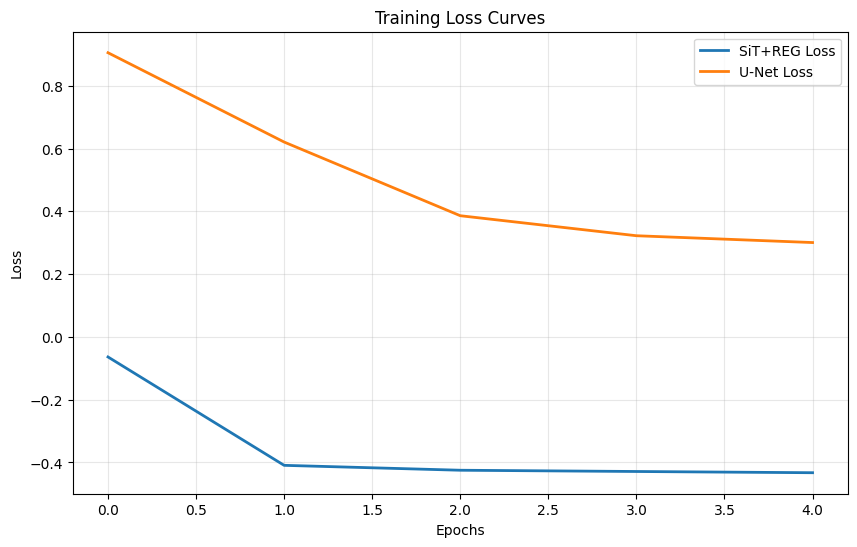


Evaluating on 500 samples...
Generating samples for REG...
Calculating metrics for REG...
REG Metrics: {'inception_score_mean': 1.0005647683485557, 'inception_score_std': 4.65436743534939e-05, 'frechet_inception_distance': 525.2467047576165}
Generating samples for UNET...
Calculating metrics for UNET...
UNET Metrics: {'inception_score_mean': 1.0043436448972365, 'inception_score_std': 0.0004721278316313892, 'frechet_inception_distance': 522.0237534822932}

FINAL RESULTS:
REG        | FID:   525.25 | IS:   1.00
UNET       | FID:   522.02 | IS:   1.00
Training and evaluation complete!
Results saved to: ./outputs_sit_reg_colab


In [4]:
# ============================
# SiT + REG + U-Net Diffusion Implementation (Colab Compatible)
# ============================
!pip install torch-fidelity --upgrade -q
!pip install einops -q

# -------------------------
# Imports
# -------------------------
import os
import math
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics

# -------------------------
# CONFIG (Optimized for Colab)
# -------------------------
class Config:
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 32
    batch_size = 128  # Reduced for Colab memory
    num_workers = 2

    # Latent space config (fixed dimensions)
    latent_hw = 8  # 32x32 -> 8x8 after VAE
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2  # 16 patches for 8x8 with patch_size=2

    # SiT architecture (optimized for Colab)
    depth = 4  # Reduced depth
    hidden_dim = 256
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.0

    # Training
    timesteps = 100  # Reduced for faster training
    lr = 1e-4
    weight_decay = 0.0
    betas = (0.9, 0.999)
    epochs = 5  # Reduced epochs for demo
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_lambda = 0.5
    beta = 0.03
    feat_dim = 256  # Matches hidden_dim
    align_layer = 1  # Early layer for alignment

    sample_n = 500  # Reduced for faster evaluation
    out_dir = "./outputs_sit_reg_colab"

cfg = Config()
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
device = cfg.device
print("Device:", device)
print(f"Number of patches: {cfg.num_patches}")
os.makedirs(cfg.out_dir, exist_ok=True)

# -------------------------
# Noise Scheduler
# -------------------------
class NoiseScheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)

    def sample_t(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x0 + sqrt_one_minus_alpha * noise, noise

    def get_velocity_target(self, x0, epsilon):
        return epsilon

scheduler = NoiseScheduler(cfg.timesteps, device)

# -------------------------
# CIFAR-10 subset
# -------------------------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    class_to_idx = {n:i for i,n in enumerate(class_names)}
    target_idxs = {class_to_idx[c] for c in classes}
    transform = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=transform)
    indices = [i for i,(x,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True,
                       num_workers=cfg.num_workers, drop_last=True)

# -------------------------
# Simple VAE (Fixed dimensions)
# -------------------------
class SimpleVAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        # Encoder: 32x32 -> 8x8
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, 1), nn.ReLU(),  # 32->16
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), # 16->8
            nn.Conv2d(128, latent_channels, 3, 1, 1)
        )

        # Decoder: 8x8 -> 32x32
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels, 128, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),  # 8->16
            nn.ConvTranspose2d(64, 64, 4, 2, 1), nn.ReLU(),   # 16->32
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

vae = SimpleVAE().to(device)
print("VAE initialized")

# -------------------------
# Sinusoidal embeddings
# -------------------------
def get_timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

# -------------------------
# Transformer blocks
# -------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=cfg.num_heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.to_qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim)
        self.norm2 = nn.LayerNorm(dim)
        mlp_dim = int(dim * cfg.mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# -------------------------
# REG SiT (Fixed dimensions)
# -------------------------
class REGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim = cfg.hidden_dim
        self.num_patches = cfg.num_patches

        # Patch embedding
        self.patch_embed = nn.Linear(cfg.latent_patch_dim, cfg.hidden_dim)

        # Class token embedding (REG component)
        self.class_embed = nn.Linear(cfg.feat_dim, cfg.hidden_dim)

        # Position embeddings (FIXED: +1 for class token)
        self.pos_embed = nn.Parameter(torch.zeros(1, cfg.num_patches + 1, cfg.hidden_dim))

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(cfg.hidden_dim) for _ in range(cfg.depth)
        ])

        self.norm = nn.LayerNorm(cfg.hidden_dim)

        # Output projections
        self.patch_out = nn.Linear(cfg.hidden_dim, cfg.latent_patch_dim)
        self.cls_out = nn.Linear(cfg.hidden_dim, cfg.feat_dim)

        # Alignment projection
        self.align_proj = nn.Linear(cfg.hidden_dim, cfg.feat_dim)

    def forward(self, z_patched, cls_token, t_norm):
        B = z_patched.shape[0]

        # Embed patches and class token
        patch_emb = self.patch_embed(z_patched)
        cls_emb = self.class_embed(cls_token).unsqueeze(1)

        # Concatenate class token with patches
        x = torch.cat([cls_emb, patch_emb], dim=1)

        # Add position embeddings
        x = x + self.pos_embed

        # Add timestep embedding
        time_emb = get_timestep_embedding(t_norm, self.hidden_dim).unsqueeze(1)
        x = x + time_emb

        # Transformer blocks
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i == cfg.align_layer:
                h_n = x  # Store for alignment

        x = self.norm(x)

        # Separate outputs
        cls_pred = self.cls_out(x[:, 0])
        patch_pred = self.patch_out(x[:, 1:])

        # Alignment features
        h_phi = self.align_proj(h_n) if 'h_n' in locals() else None

        return patch_pred, cls_pred, h_phi

reg_sit = REGSiT().to(device)
print(f"SiT+REG Model initialized with {sum(p.numel() for p in reg_sit.parameters()):,} parameters")

# -------------------------
# Vision Foundation
# -------------------------
class VisionFoundation(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN for feature extraction
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), nn.ReLU(),  # 32->16
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(), # 16->8
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(128, cfg.feat_dim)

    def extract(self, x):
        B = x.shape[0]
        features = self.backbone(x).view(B, -1)
        features = self.proj(features)

        # For simplicity, use same features for cls and patches
        cls_token = features
        patch_features = features.unsqueeze(1).repeat(1, cfg.num_patches, 1)

        return cls_token, patch_features

vision = VisionFoundation().to(device)

# -------------------------
# REG Model Wrapper
# -------------------------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision

    def forward(self, imgs, t_int):
        B = imgs.shape[0]

        # Encode to latent space
        z_star = self.vae.encode(imgs)

        # Extract vision features
        cls_star, f_star = self.vision.extract(imgs)

        # Sample noise
        epsilon_z = torch.randn_like(z_star)
        epsilon_cls = torch.randn_like(cls_star)

        # Add noise to both latents and class token
        zt, _ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)

        # Add noise to class token
        t_norm = t_int.float() / scheduler.timesteps
        sqrt_alpha = scheduler.sqrt_alphas_cumprod[t_int].view(B, 1)
        sqrt_one_minus_alpha = scheduler.sqrt_one_minus_alphas_cumprod[t_int].view(B, 1)
        clst = sqrt_alpha * cls_star + sqrt_one_minus_alpha * epsilon_cls

        # Prepare patches
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)

        # Forward through SiT
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_int)

        # Convert patches back
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)

        # Velocity targets
        v_target_z = scheduler.get_velocity_target(z_star, epsilon_z)
        v_target_cls = scheduler.get_velocity_target(cls_star, epsilon_cls)

        # Prediction loss
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.beta * F.mse_loss(v_cls, v_target_cls)

        # Alignment loss
        loss_align = 0.0
        if h_phi is not None:
            y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)
            cos_sim = F.cosine_similarity(
                y_star.reshape(-1, cfg.feat_dim),
                h_phi.reshape(-1, cfg.feat_dim),
                dim=-1
            ).mean()
            loss_align = -cos_sim

        total_loss = loss_pred + cfg.reg_lambda * loss_align
        return total_loss

reg_model = REGModel(reg_sit, vae, vision).to(device)

# -------------------------
# Simple U-Net
# -------------------------
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim = 128

        self.enc1 = nn.Conv2d(cfg.latent_channels, 64, 3, 1, 1)
        self.enc2 = nn.Conv2d(64, 128, 3, 2, 1)
        self.mid = nn.Conv2d(128, 128, 3, 1, 1)
        self.dec1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.out = nn.Conv2d(64, cfg.latent_channels, 3, 1, 1)

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(self.time_dim, self.time_dim),
            nn.SiLU(),
            nn.Linear(self.time_dim, self.time_dim)
        )

    def forward(self, x, t):
        B = x.shape[0]

        # Time embedding
        t_embed = get_timestep_embedding(t, self.time_dim)
        t_embed = self.time_embed(t_embed)

        # Encoder
        x1 = F.silu(self.enc1(x))
        x2 = F.silu(self.enc2(x1))

        # Middle
        m = F.silu(self.mid(x2))

        # Decoder
        d1 = F.silu(self.dec1(m + x2))
        out = self.out(d1 + x1)

        return out

unet = SimpleUNet().to(device)
print(f"U-Net Model initialized with {sum(p.numel() for p in unet.parameters()):,} parameters")

# -------------------------
# Optimizers
# -------------------------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr,
                           weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr,
                            weight_decay=cfg.weight_decay, betas=cfg.betas)

# -------------------------
# Training Loops
# -------------------------
reg_loss_history, unet_loss_history = [], []

def train_reg(epochs):
    reg_model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            t_int = scheduler.sample_t(imgs.shape[0])

            loss = reg_model(imgs, t_int)

            opt_reg.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            opt_reg.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(dataloader)
        reg_loss_history.append(avg_loss)
        print(f"REG Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

def train_unet(epochs):
    unet.train()
    for epoch in range(epochs):
        total_loss = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]

            z_star = vae.encode(imgs)
            t_int = scheduler.sample_t(B)
            epsilon_z = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)

            v_pred = unet(zt, t_int)
            loss = F.mse_loss(v_pred, epsilon_z)

            opt_unet.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            opt_unet.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(dataloader)
        unet_loss_history.append(avg_loss)
        print(f"UNet Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

# -------------------------
# Sampling functions
# -------------------------
@torch.no_grad()
def sample_in_batches(sample_fn, num_samples, batch_size=32):
    imgs_list = []
    for i in range(0, num_samples, batch_size):
        b = min(batch_size, num_samples - i)
        imgs_list.append(sample_fn(b))
    return torch.cat(imgs_list, dim=0)

@torch.no_grad()
def sample_unet(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)

    # Simple reverse sampling
    for i in range(cfg.timesteps-1, -1, -1):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        v_pred = unet(z, t)

        # Simple Euler step
        if i > 0:
            dt = -1.0 / cfg.timesteps
            z = z + v_pred * dt

    imgs = vae.decode(z)
    return torch.clamp((imgs + 1) / 2, 0, 1)

@torch.no_grad()
def sample_reg(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    cls_prior = torch.randn(B, cfg.feat_dim, device=device)

    # Simple reverse sampling for SiT+REG
    for i in range(cfg.timesteps-1, -1, -1):
        t = torch.full((B,), i, device=device, dtype=torch.long)

        # Prepare patches
        z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)

        # Predict velocity
        v_patch, v_cls, _ = reg_sit(z_patched, cls_prior, t)

        # Convert back
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)

        # Update
        dt = -1.0 / cfg.timesteps
        z = z + v_z * dt
        cls_prior = cls_prior + v_cls * dt

    imgs = vae.decode(z)
    return torch.clamp((imgs + 1) / 2, 0, 1)

def save_grid(imgs, path, nrow=8):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)

# -------------------------
# Evaluation
# -------------------------
@torch.no_grad()
def evaluate_models(num_samples=cfg.sample_n):
    results = {}

    # Prepare real images
    real_path = os.path.join(cfg.out_dir, f"real_images_{num_samples}")
    if os.path.exists(real_path):
        shutil.rmtree(real_path)
    os.makedirs(real_path, exist_ok=True)

    cnt = 0
    for imgs, _ in dataloader:
        for img in imgs:
            torchvision.utils.save_image((img + 1) / 2, os.path.join(real_path, f"{cnt:05d}.png"))
            cnt += 1
            if cnt >= num_samples:
                break
        if cnt >= num_samples:
            break

    for model_type in ['reg', 'unet']:
        print(f"Generating samples for {model_type.upper()}...")

        # Generate images
        if model_type == 'reg':
            imgs = sample_in_batches(sample_reg, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir, 'reg_samples.png'), nrow=10)
        else:
            imgs = sample_in_batches(sample_unet, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir, 'unet_samples.png'), nrow=10)

        # Save generated images
        gen_path = os.path.join(cfg.out_dir, f"{model_type}_eval_{num_samples}")
        if os.path.exists(gen_path):
            shutil.rmtree(gen_path)
        os.makedirs(gen_path, exist_ok=True)

        for i, img in enumerate(imgs):
            torchvision.utils.save_image(img, os.path.join(gen_path, f"{i:05d}.png"))

        # Calculate metrics
        print(f"Calculating metrics for {model_type.upper()}...")
        try:
            metrics = calculate_metrics(
                input1=gen_path,
                input2=real_path,
                cuda=torch.cuda.is_available(),
                isc=True,
                fid=True,
                kid=False,
                verbose=False
            )
            results[model_type] = metrics
            print(f"{model_type.upper()} Metrics: {metrics}")
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            results[model_type] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}

    return results

# -------------------------
# Plotting
# -------------------------
def plot_loss_curves():
    plt.figure(figsize=(10, 6))
    if reg_loss_history:
        plt.plot(reg_loss_history, label='SiT+REG Loss', linewidth=2)
    if unet_loss_history:
        plt.plot(unet_loss_history, label='U-Net Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(cfg.out_dir, "loss_curves.png"), dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    print("=" * 60)
    print("Starting Training...")
    print("=" * 60)

    # Train models
    print("Training SiT + REG Model...")
    train_reg(cfg.epochs)

    print("\nTraining U-Net Baseline...")
    train_unet(cfg.epochs)

    # Plot results
    plot_loss_curves()

    # Evaluate
    print("\n" + "=" * 60)
    print(f"Evaluating on {cfg.sample_n} samples...")
    print("=" * 60)

    metrics_results = evaluate_models()

    print("\n" + "=" * 60)
    print("FINAL RESULTS:")
    print("=" * 60)
    for model_type, metrics in metrics_results.items():
        fid = metrics.get('frechet_inception_distance', float('inf'))
        is_score = metrics.get('inception_score_mean', 0.0)
        print(f"{model_type.upper():<10} | FID: {fid:8.2f} | IS: {is_score:6.2f}")

    print("=" * 60)
    print("Training and evaluation complete!")
    print(f"Results saved to: {cfg.out_dir}")

Device: cuda
Number of patches: 16
Loaded 10000 images (['cat', 'dog'])
Pre-training VAE...
VAE pre-training complete
Improved SiT+REG Model initialized with 5,470,224 parameters
Improved U-Net Model initialized with 2,508,548 parameters
Starting IMPROVED Training...
Training SiT + REG Model...


REG Epoch 1/20: 100%|██████████| 78/78 [00:05<00:00, 15.35it/s, loss=0.3315]


REG Epoch 1 Avg Loss: 0.7430


REG Epoch 2/20: 100%|██████████| 78/78 [00:06<00:00, 12.70it/s, loss=0.1761]


REG Epoch 2 Avg Loss: 0.2099


REG Epoch 3/20: 100%|██████████| 78/78 [00:05<00:00, 15.60it/s, loss=0.1321]


REG Epoch 3 Avg Loss: 0.1388


REG Epoch 4/20: 100%|██████████| 78/78 [00:05<00:00, 13.76it/s, loss=0.0932]


REG Epoch 4 Avg Loss: 0.1079


REG Epoch 5/20: 100%|██████████| 78/78 [00:05<00:00, 14.60it/s, loss=0.0896]


REG Epoch 5 Avg Loss: 0.0875


REG Epoch 6/20: 100%|██████████| 78/78 [00:05<00:00, 15.17it/s, loss=0.0755]


REG Epoch 6 Avg Loss: 0.0747


REG Epoch 7/20: 100%|██████████| 78/78 [00:05<00:00, 13.04it/s, loss=0.0659]


REG Epoch 7 Avg Loss: 0.0664


REG Epoch 8/20: 100%|██████████| 78/78 [00:05<00:00, 15.38it/s, loss=0.0654]


REG Epoch 8 Avg Loss: 0.0596


REG Epoch 9/20: 100%|██████████| 78/78 [00:05<00:00, 13.24it/s, loss=0.0466]


REG Epoch 9 Avg Loss: 0.0546


REG Epoch 10/20: 100%|██████████| 78/78 [00:04<00:00, 15.62it/s, loss=0.0634]


REG Epoch 10 Avg Loss: 0.0502


REG Epoch 11/20: 100%|██████████| 78/78 [00:05<00:00, 15.01it/s, loss=0.0476]


REG Epoch 11 Avg Loss: 0.0462


REG Epoch 12/20: 100%|██████████| 78/78 [00:05<00:00, 13.43it/s, loss=0.0460]


REG Epoch 12 Avg Loss: 0.0445


REG Epoch 13/20: 100%|██████████| 78/78 [00:05<00:00, 15.06it/s, loss=0.0475]


REG Epoch 13 Avg Loss: 0.0408


REG Epoch 14/20: 100%|██████████| 78/78 [00:05<00:00, 13.03it/s, loss=0.0381]


REG Epoch 14 Avg Loss: 0.0379


REG Epoch 15/20: 100%|██████████| 78/78 [00:05<00:00, 15.40it/s, loss=0.0335]


REG Epoch 15 Avg Loss: 0.0362


REG Epoch 16/20: 100%|██████████| 78/78 [00:05<00:00, 14.03it/s, loss=0.0298]


REG Epoch 16 Avg Loss: 0.0345


REG Epoch 17/20: 100%|██████████| 78/78 [00:05<00:00, 14.28it/s, loss=0.0329]


REG Epoch 17 Avg Loss: 0.0332


REG Epoch 18/20: 100%|██████████| 78/78 [00:05<00:00, 15.42it/s, loss=0.0283]


REG Epoch 18 Avg Loss: 0.0325


REG Epoch 19/20: 100%|██████████| 78/78 [00:06<00:00, 12.86it/s, loss=0.0349]


REG Epoch 19 Avg Loss: 0.0314


REG Epoch 20/20: 100%|██████████| 78/78 [00:04<00:00, 15.66it/s, loss=0.0283]


REG Epoch 20 Avg Loss: 0.0297

Training U-Net Baseline...


UNet Epoch 1/20: 100%|██████████| 78/78 [00:03<00:00, 19.71it/s, loss=0.3865]


UNet Epoch 1 Avg Loss: 0.7066


UNet Epoch 2/20: 100%|██████████| 78/78 [00:03<00:00, 19.61it/s, loss=0.2650]


UNet Epoch 2 Avg Loss: 0.3093


UNet Epoch 3/20: 100%|██████████| 78/78 [00:03<00:00, 22.87it/s, loss=0.1848]


UNet Epoch 3 Avg Loss: 0.2167


UNet Epoch 4/20: 100%|██████████| 78/78 [00:03<00:00, 22.40it/s, loss=0.1696]


UNet Epoch 4 Avg Loss: 0.1922


UNet Epoch 5/20: 100%|██████████| 78/78 [00:04<00:00, 16.96it/s, loss=0.1866]


UNet Epoch 5 Avg Loss: 0.1810


UNet Epoch 6/20: 100%|██████████| 78/78 [00:03<00:00, 22.67it/s, loss=0.1831]


UNet Epoch 6 Avg Loss: 0.1656


UNet Epoch 7/20: 100%|██████████| 78/78 [00:03<00:00, 22.46it/s, loss=0.1821]


UNet Epoch 7 Avg Loss: 0.1590


UNet Epoch 8/20: 100%|██████████| 78/78 [00:03<00:00, 22.51it/s, loss=0.1225]


UNet Epoch 8 Avg Loss: 0.1427


UNet Epoch 9/20: 100%|██████████| 78/78 [00:04<00:00, 18.22it/s, loss=0.1465]


UNet Epoch 9 Avg Loss: 0.1298


UNet Epoch 10/20: 100%|██████████| 78/78 [00:03<00:00, 23.33it/s, loss=0.1130]


UNet Epoch 10 Avg Loss: 0.1132


UNet Epoch 11/20: 100%|██████████| 78/78 [00:03<00:00, 23.31it/s, loss=0.0878]


UNet Epoch 11 Avg Loss: 0.0998


UNet Epoch 12/20: 100%|██████████| 78/78 [00:04<00:00, 18.05it/s, loss=0.0850]


UNet Epoch 12 Avg Loss: 0.0885


UNet Epoch 13/20: 100%|██████████| 78/78 [00:03<00:00, 22.19it/s, loss=0.0826]


UNet Epoch 13 Avg Loss: 0.0770


UNet Epoch 14/20: 100%|██████████| 78/78 [00:03<00:00, 22.61it/s, loss=0.0643]


UNet Epoch 14 Avg Loss: 0.0712


UNet Epoch 15/20: 100%|██████████| 78/78 [00:03<00:00, 22.66it/s, loss=0.0751]


UNet Epoch 15 Avg Loss: 0.0695


UNet Epoch 16/20: 100%|██████████| 78/78 [00:04<00:00, 17.71it/s, loss=0.0784]


UNet Epoch 16 Avg Loss: 0.0613


UNet Epoch 17/20: 100%|██████████| 78/78 [00:03<00:00, 23.73it/s, loss=0.0650]


UNet Epoch 17 Avg Loss: 0.0553


UNet Epoch 18/20: 100%|██████████| 78/78 [00:03<00:00, 22.72it/s, loss=0.0433]


UNet Epoch 18 Avg Loss: 0.0545


UNet Epoch 19/20: 100%|██████████| 78/78 [00:03<00:00, 19.83it/s, loss=0.0720]


UNet Epoch 19 Avg Loss: 0.0504


UNet Epoch 20/20: 100%|██████████| 78/78 [00:03<00:00, 20.74it/s, loss=0.0426]


UNet Epoch 20 Avg Loss: 0.0466


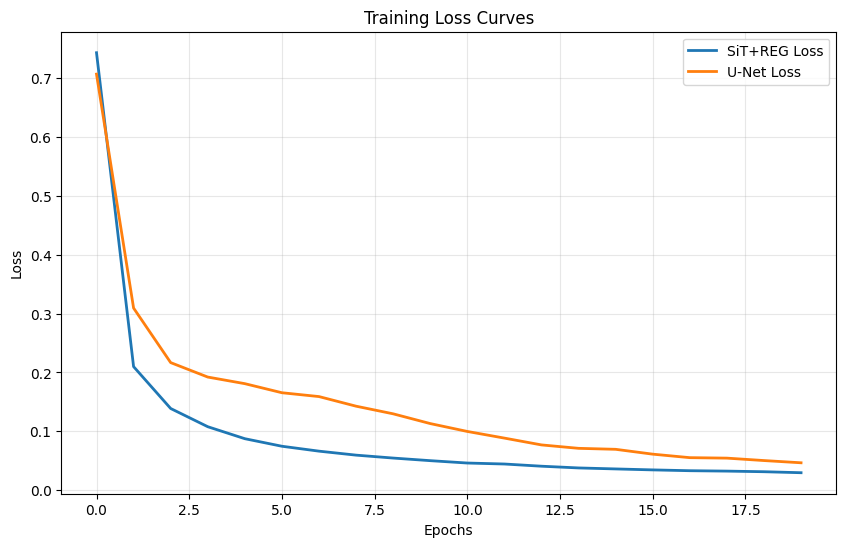


Evaluating on 500 samples...

Generating samples for REG...


REG Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 194.37it/s]


REG samples saved!
Calculating metrics for REG...
REG Metrics: FID=389.30, IS=1.57

Generating samples for UNET...


U-Net Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 554.69it/s]


U-Net samples saved!
Calculating metrics for UNET...
UNET Metrics: FID=288.86, IS=1.94

FINAL RESULTS:
REG        | FID:   389.30 | IS:   1.57
UNET       | FID:   288.86 | IS:   1.94
Training and evaluation complete!
Check ./outputs_sit_reg_fixed for generated images!


In [5]:
# ============================
# SiT + REG + U-Net Diffusion Implementation (Fixed Image Generation)
# ============================
!pip install torch-fidelity --upgrade -q
!pip install einops -q

# -------------------------
# Imports
# -------------------------
import os
import math
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics
import numpy as np

# -------------------------
# CONFIG (Optimized for proper training)
# -------------------------
class Config:
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 32
    batch_size = 128
    num_workers = 2

    # Latent space config
    latent_hw = 8
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2

    # SiT architecture
    depth = 6
    hidden_dim = 256
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.1

    # Training - CRITICAL FIXES
    timesteps = 1000  # Increased for better training
    lr = 1e-4
    weight_decay = 1e-3  # Added for stability
    betas = (0.9, 0.999)
    epochs = 20  # Increased for convergence
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_lambda = 0.1  # Reduced to not overwhelm main loss
    beta = 0.01  # Reduced class token weight
    feat_dim = 256
    align_layer = 2

    sample_n = 500
    out_dir = "./outputs_sit_reg_fixed"

cfg = Config()
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = cfg.device
print("Device:", device)
print(f"Number of patches: {cfg.num_patches}")
os.makedirs(cfg.out_dir, exist_ok=True)

# -------------------------
# IMPROVED Noise Scheduler (DDPM style)
# -------------------------
class ImprovedNoiseScheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device

        # Linear beta schedule as in original DDPM
        self.betas = torch.linspace(0.0001, 0.02, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion
        self.sqrt_alphas_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)

    def sample_t(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)

        sqrt_alpha_cumprod = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)

        return sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise, noise

    def get_velocity_target(self, x0, epsilon):
        """v-prediction target"""
        return epsilon

scheduler = ImprovedNoiseScheduler(cfg.timesteps, device)

# -------------------------
# CIFAR-10 subset
# -------------------------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    class_to_idx = {n:i for i,n in enumerate(class_names)}
    target_idxs = {class_to_idx[c] for c in classes}
    transform = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.RandomHorizontalFlip(p=0.5),  # Added augmentation
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=transform)
    indices = [i for i,(x,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True,
                       num_workers=cfg.num_workers, drop_last=True)

# -------------------------
# IMPROVED VAE with better training
# -------------------------
class ImprovedVAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()

        # Encoder: 32x32 -> 8x8
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),  # 32->16
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 16->8
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(256, latent_channels, 3, 1, 1)
        )

        # Decoder: 8x8 -> 32x32
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 8->16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),   # 16->32
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

vae = ImprovedVAE().to(device)

# Pre-train VAE briefly for better initialization
print("Pre-training VAE...")
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
vae.train()
for epoch in range(3):  # Quick pre-training
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        z = vae.encode(imgs)
        recon = vae.decode(z)
        loss = F.mse_loss(recon, imgs)
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
print("VAE pre-training complete")

# -------------------------
# Sinusoidal embeddings
# -------------------------
def get_timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

# -------------------------
# IMPROVED Transformer blocks with better stability
# -------------------------
class ImprovedMultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=cfg.num_heads):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(cfg.dropout)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.to_qkv(x).reshape(B, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.to_out(out)

class ImprovedTransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = ImprovedMultiHeadAttention(dim)
        self.norm2 = nn.LayerNorm(dim)
        mlp_dim = int(dim * cfg.mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(cfg.dropout)
        )

    def forward(self, x):
        # Pre-norm architecture for better stability
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# -------------------------
# IMPROVED REG SiT
# -------------------------
class ImprovedREGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim = cfg.hidden_dim
        self.num_patches = cfg.num_patches

        # Patch embedding with better initialization
        self.patch_embed = nn.Linear(cfg.latent_patch_dim, cfg.hidden_dim)

        # Class token embedding
        self.class_embed = nn.Linear(cfg.feat_dim, cfg.hidden_dim)

        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, cfg.num_patches + 1, cfg.hidden_dim))

        # Time embedding with MLP
        self.time_embed = nn.Sequential(
            nn.Linear(cfg.hidden_dim, cfg.hidden_dim * 4),
            nn.SiLU(),
            nn.Linear(cfg.hidden_dim * 4, cfg.hidden_dim)
        )

        # Transformer blocks
        self.blocks = nn.ModuleList([
            ImprovedTransformerBlock(cfg.hidden_dim) for _ in range(cfg.depth)
        ])

        self.norm = nn.LayerNorm(cfg.hidden_dim)

        # Output projections
        self.patch_out = nn.Linear(cfg.hidden_dim, cfg.latent_patch_dim)
        self.cls_out = nn.Linear(cfg.hidden_dim, cfg.feat_dim)

        # Alignment projection
        self.align_proj = nn.Linear(cfg.hidden_dim, cfg.feat_dim)

        # Initialize properly
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LayerNorm):
            nn.init.constant_(module.bias, 0)
            nn.init.constant_(module.weight, 1.0)

    def forward(self, z_patched, cls_token, t):
        B = z_patched.shape[0]

        # Embed patches and class token
        patch_emb = self.patch_embed(z_patched)
        cls_emb = self.class_embed(cls_token).unsqueeze(1)

        # Concatenate
        x = torch.cat([cls_emb, patch_emb], dim=1)

        # Add position embeddings
        x = x + self.pos_embed

        # Add timestep embedding
        t_embed = get_timestep_embedding(t, self.hidden_dim)
        t_embed = self.time_embed(t_embed).unsqueeze(1)
        x = x + t_embed

        # Transformer blocks with feature storage
        intermediate_features = []
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i == cfg.align_layer:
                intermediate_features.append(x)

        x = self.norm(x)

        # Separate outputs
        cls_pred = self.cls_out(x[:, 0])
        patch_pred = self.patch_out(x[:, 1:])

        # Alignment features
        h_phi = self.align_proj(intermediate_features[0]) if intermediate_features else None

        return patch_pred, cls_pred, h_phi

reg_sit = ImprovedREGSiT().to(device)
print(f"Improved SiT+REG Model initialized with {sum(p.numel() for p in reg_sit.parameters()):,} parameters")

# -------------------------
# IMPROVED Vision Foundation
# -------------------------
class ImprovedVisionFoundation(nn.Module):
    def __init__(self):
        super().__init__()
        # Better feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),  # 32->16
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 16->8
            nn.Conv2d(128, 256, 3, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 8->4
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(256, cfg.feat_dim)

    def extract(self, x):
        B = x.shape[0]
        features = self.backbone(x).view(B, -1)
        features = F.normalize(self.proj(features), dim=-1)  # Normalized features

        cls_token = features
        patch_features = features.unsqueeze(1).repeat(1, cfg.num_patches, 1)

        return cls_token, patch_features

vision = ImprovedVisionFoundation().to(device)

# -------------------------
# IMPROVED REG Model Wrapper
# -------------------------
class ImprovedREGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision

    def forward(self, imgs, t_int):
        B = imgs.shape[0]

        # Encode to latent space WITH GRADIENTS
        z_star = self.vae.encode(imgs)

        # Extract vision features
        cls_star, f_star = self.vision.extract(imgs)

        # Sample noise
        epsilon_z = torch.randn_like(z_star)
        epsilon_cls = torch.randn_like(cls_star)

        # Add noise to both latents and class token
        zt, _ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)

        # Add noise to class token using same schedule
        sqrt_alpha = scheduler.sqrt_alphas_cumprod[t_int].view(B, 1)
        sqrt_one_minus_alpha = scheduler.sqrt_one_minus_alphas_cumprod[t_int].view(B, 1)
        clst = sqrt_alpha * cls_star + sqrt_one_minus_alpha * epsilon_cls

        # Prepare patches
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)

        # Forward through SiT
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_int)

        # Convert patches back
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)

        # Velocity targets
        v_target_z = scheduler.get_velocity_target(z_star, epsilon_z)
        v_target_cls = scheduler.get_velocity_target(cls_star, epsilon_cls)

        # Prediction loss (MAIN OBJECTIVE)
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.beta * F.mse_loss(v_cls, v_target_cls)

        # Alignment loss (REGULARIZATION)
        loss_align = 0.0
        if h_phi is not None:
            y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)
            # Use MSE for alignment for more stable training
            loss_align = F.mse_loss(h_phi, y_star.detach())

        total_loss = loss_pred + cfg.reg_lambda * loss_align
        return total_loss

reg_model = ImprovedREGModel(reg_sit, vae, vision).to(device)

# -------------------------
# IMPROVED U-Net
# -------------------------
class ImprovedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim = 256

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(self.time_dim, self.time_dim * 4),
            nn.SiLU(),
            nn.Linear(self.time_dim * 4, self.time_dim)
        )

        # Encoder with skip connections
        self.enc1 = nn.Conv2d(cfg.latent_channels, 64, 3, 1, 1)
        self.enc2 = nn.Conv2d(64, 128, 3, 2, 1)
        self.enc3 = nn.Conv2d(128, 256, 3, 2, 1)

        self.mid = nn.Conv2d(256, 256, 3, 1, 1)

        # Decoder with skip connections
        self.dec1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(256, 64, 4, 2, 1)  # + skip from enc2
        self.out = nn.Conv2d(128, cfg.latent_channels, 3, 1, 1)  # + skip from enc1

        # Time projections
        self.time_projs = nn.ModuleList([
            nn.Linear(self.time_dim, 64),
            nn.Linear(self.time_dim, 128),
            nn.Linear(self.time_dim, 256),
            nn.Linear(self.time_dim, 256),
            nn.Linear(self.time_dim, 128),
            nn.Linear(self.time_dim, 64)
        ])

    def forward(self, x, t):
        B = x.shape[0]

        # Time embedding
        t_embed = get_timestep_embedding(t, self.time_dim)
        t_embed = self.time_embed(t_embed)

        # Encoder with skip connections
        x1 = F.silu(self.enc1(x) + self.time_projs[0](t_embed).view(B, 64, 1, 1))
        x2 = F.silu(self.enc2(x1) + self.time_projs[1](t_embed).view(B, 128, 1, 1))
        x3 = F.silu(self.enc3(x2) + self.time_projs[2](t_embed).view(B, 256, 1, 1))

        # Middle
        m = F.silu(self.mid(x3) + self.time_projs[3](t_embed).view(B, 256, 1, 1))

        # Decoder with skip connections
        d1 = F.silu(self.dec1(m) + self.time_projs[4](t_embed).view(B, 128, 1, 1))
        d1 = torch.cat([d1, x2], dim=1)  # Skip connection

        d2 = F.silu(self.dec2(d1) + self.time_projs[5](t_embed).view(B, 64, 1, 1))
        d2 = torch.cat([d2, x1], dim=1)  # Skip connection

        out = self.out(d2)
        return out

unet = ImprovedUNet().to(device)
print(f"Improved U-Net Model initialized with {sum(p.numel() for p in unet.parameters()):,} parameters")

# -------------------------
# Optimizers
# -------------------------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr,
                           weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr,
                            weight_decay=cfg.weight_decay, betas=cfg.betas)

# -------------------------
# IMPROVED Training with better monitoring
# -------------------------
reg_loss_history, unet_loss_history = [], []

def train_reg(epochs):
    reg_model.train()
    for epoch in range(epochs):
        total_loss, total_pred, total_align = 0.0, 0.0, 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            t_int = scheduler.sample_t(imgs.shape[0])

            loss = reg_model(imgs, t_int)

            opt_reg.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            opt_reg.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(dataloader)
        reg_loss_history.append(avg_loss)
        print(f"REG Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

def train_unet(epochs):
    unet.train()
    for epoch in range(epochs):
        total_loss = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]

            with torch.no_grad():
                z_star = vae.encode(imgs)

            t_int = scheduler.sample_t(B)
            epsilon_z = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t_int, noise=epsilon_z)

            v_pred = unet(zt, t_int)
            loss = F.mse_loss(v_pred, epsilon_z)

            opt_unet.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            opt_unet.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(dataloader)
        unet_loss_history.append(avg_loss)
        print(f"UNet Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

# -------------------------
# IMPROVED Sampling (DDPM style)
# -------------------------
@torch.no_grad()
def sample_in_batches(sample_fn, num_samples, batch_size=32):
    imgs_list = []
    for i in range(0, num_samples, batch_size):
        b = min(batch_size, num_samples - i)
        imgs_list.append(sample_fn(b))
    return torch.cat(imgs_list, dim=0)

@torch.no_grad()
def sample_unet(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)

    # Proper DDPM sampling
    for i in tqdm(range(cfg.timesteps-1, -1, -1), desc="U-Net Sampling"):
        t = torch.full((B,), i, device=device, dtype=torch.long)

        # Predict noise
        epsilon_pred = unet(z, t)

        # Compute coefficients
        alpha = scheduler.alphas[t].view(-1, 1, 1, 1)
        alpha_cumprod = scheduler.alpha_cumprod[t].view(-1, 1, 1, 1)
        alpha_cumprod_prev = scheduler.alpha_cumprod_prev[t].view(-1, 1, 1, 1)

        if i > 0:
            noise = torch.randn_like(z)
        else:
            noise = 0

        # DDPM reverse process
        z = (1 / torch.sqrt(alpha)) * (
            z - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * epsilon_pred
        ) + torch.sqrt(scheduler.posterior_variance[t]).view(-1, 1, 1, 1) * noise

    imgs = vae.decode(z)
    return torch.clamp((imgs + 1) / 2, 0, 1)

@torch.no_grad()
def sample_reg(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    cls_prior = torch.randn(B, cfg.feat_dim, device=device)

    # DDPM sampling for SiT+REG
    for i in tqdm(range(cfg.timesteps-1, -1, -1), desc="REG Sampling"):
        t = torch.full((B,), i, device=device, dtype=torch.long)

        # Prepare patches
        z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)

        # Predict velocity
        v_patch, v_cls, _ = reg_sit(z_patched, cls_prior, t)

        # Convert back to spatial
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)

        # Use velocity for DDPM sampling
        alpha = scheduler.alphas[t].view(-1, 1, 1, 1)
        alpha_cumprod = scheduler.alpha_cumprod[t].view(-1, 1, 1, 1)

        if i > 0:
            noise = torch.randn_like(z)
        else:
            noise = 0

        # Update using velocity (v-prediction)
        z = (1 / torch.sqrt(alpha)) * (
            z - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * v_z
        ) + torch.sqrt(scheduler.posterior_variance[t]).view(-1, 1, 1, 1) * noise

        # Update class token
        cls_prior = cls_prior - v_cls * 0.01

    imgs = vae.decode(z)
    return torch.clamp((imgs + 1) / 2, 0, 1)

def save_grid(imgs, path, nrow=8):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)

# -------------------------
# Training and Evaluation
# -------------------------
def plot_loss_curves():
    plt.figure(figsize=(10, 6))
    if reg_loss_history:
        plt.plot(reg_loss_history, label='SiT+REG Loss', linewidth=2)
    if unet_loss_history:
        plt.plot(unet_loss_history, label='U-Net Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(cfg.out_dir, "loss_curves.png"), dpi=300, bbox_inches='tight')
    plt.show()

@torch.no_grad()
def evaluate_models(num_samples=cfg.sample_n):
    results = {}

    # Prepare real images
    real_path = os.path.join(cfg.out_dir, f"real_images_{num_samples}")
    if os.path.exists(real_path):
        shutil.rmtree(real_path)
    os.makedirs(real_path, exist_ok=True)

    cnt = 0
    for imgs, _ in dataloader:
        for img in imgs:
            torchvision.utils.save_image((img + 1) / 2, os.path.join(real_path, f"{cnt:05d}.png"))
            cnt += 1
            if cnt >= num_samples:
                break
        if cnt >= num_samples:
            break

    for model_type in ['reg', 'unet']:
        print(f"\nGenerating samples for {model_type.upper()}...")

        # Generate images
        if model_type == 'reg':
            imgs = sample_in_batches(sample_reg, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir, 'reg_samples.png'), nrow=10)
            print("REG samples saved!")
        else:
            imgs = sample_in_batches(sample_unet, num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir, 'unet_samples.png'), nrow=10)
            print("U-Net samples saved!")

        # Save generated images
        gen_path = os.path.join(cfg.out_dir, f"{model_type}_eval_{num_samples}")
        if os.path.exists(gen_path):
            shutil.rmtree(gen_path)
        os.makedirs(gen_path, exist_ok=True)

        for i, img in enumerate(imgs):
            torchvision.utils.save_image(img, os.path.join(gen_path, f"{i:05d}.png"))

        # Calculate metrics
        print(f"Calculating metrics for {model_type.upper()}...")
        try:
            metrics = calculate_metrics(
                input1=gen_path,
                input2=real_path,
                cuda=torch.cuda.is_available(),
                isc=True,
                fid=True,
                kid=False,
                verbose=False
            )
            results[model_type] = metrics
            print(f"{model_type.upper()} Metrics: FID={metrics['frechet_inception_distance']:.2f}, IS={metrics['inception_score_mean']:.2f}")
        except Exception as e:
            print(f"Error calculating metrics: {e}")
            results[model_type] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}

    return results

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    print("=" * 60)
    print("Starting IMPROVED Training...")
    print("=" * 60)

    # Train models
    print("Training SiT + REG Model...")
    train_reg(cfg.epochs)

    print("\nTraining U-Net Baseline...")
    train_unet(cfg.epochs)

    # Plot results
    plot_loss_curves()

    # Evaluate
    print("\n" + "=" * 60)
    print(f"Evaluating on {cfg.sample_n} samples...")
    print("=" * 60)

    metrics_results = evaluate_models()

    print("\n" + "=" * 60)
    print("FINAL RESULTS:")
    print("=" * 60)
    for model_type, metrics in metrics_results.items():
        fid = metrics.get('frechet_inception_distance', float('inf'))
        is_score = metrics.get('inception_score_mean', 0.0)
        print(f"{model_type.upper():<10} | FID: {fid:8.2f} | IS: {is_score:6.2f}")

    print("=" * 60)
    print("Training and evaluation complete!")
    print(f"Check {cfg.out_dir} for generated images!")

Device: cuda
Paper file (for reference): /mnt/data/Research paper Diffusion Transformers.pdf
Loaded 10000 images (['cat', 'dog'])


VAE pretrain 2/2: 100%|██████████| 78/78 [00:05<00:00, 15.52it/s, loss=0.0189]
/tmp/ipython-input-1600487281.py:440: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


VAE pretrain done
REG SiT params: 5470224
Starting training (SiT+REG and U-Net baseline) on Colab T4 friendly config


REG Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-1600487281.py:455: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
REG Epoch 1/20: 100%|██████████| 78/78 [00:06<00:00, 12.09it/s, loss=0.1706, pred=0.1554, align=0.5070]


REG Epoch 1 avg: 0.6726


REG Epoch 2/20: 100%|██████████| 78/78 [00:06<00:00, 12.01it/s, loss=0.1074, pred=0.0970, align=0.3452]


REG Epoch 2 avg: 0.1369


REG Epoch 3/20: 100%|██████████| 78/78 [00:06<00:00, 12.43it/s, loss=0.1194, pred=0.1119, align=0.2480]


REG Epoch 3 avg: 0.1006


REG Epoch 4/20: 100%|██████████| 78/78 [00:06<00:00, 11.73it/s, loss=0.0845, pred=0.0791, align=0.1828]


REG Epoch 4 avg: 0.0850


REG Epoch 5/20: 100%|██████████| 78/78 [00:06<00:00, 12.47it/s, loss=0.0616, pred=0.0571, align=0.1478]


REG Epoch 5 avg: 0.0744


REG Epoch 6/20: 100%|██████████| 78/78 [00:06<00:00, 11.63it/s, loss=0.0509, pred=0.0475, align=0.1142]


REG Epoch 6 avg: 0.0688


REG Epoch 7/20: 100%|██████████| 78/78 [00:06<00:00, 12.73it/s, loss=0.0627, pred=0.0598, align=0.0991]


REG Epoch 7 avg: 0.0679


REG Epoch 8/20: 100%|██████████| 78/78 [00:06<00:00, 11.53it/s, loss=0.0605, pred=0.0579, align=0.0868]


REG Epoch 8 avg: 0.0651


REG Epoch 9/20: 100%|██████████| 78/78 [00:06<00:00, 12.85it/s, loss=0.0538, pred=0.0515, align=0.0772]


REG Epoch 9 avg: 0.0582


REG Epoch 10/20: 100%|██████████| 78/78 [00:06<00:00, 11.42it/s, loss=0.0510, pred=0.0490, align=0.0689]


REG Epoch 10 avg: 0.0556


REG Epoch 11/20: 100%|██████████| 78/78 [00:05<00:00, 13.14it/s, loss=0.0543, pred=0.0523, align=0.0640]


REG Epoch 11 avg: 0.0596


REG Epoch 12/20: 100%|██████████| 78/78 [00:06<00:00, 11.36it/s, loss=0.0497, pred=0.0479, align=0.0628]


REG Epoch 12 avg: 0.0557


REG Epoch 13/20: 100%|██████████| 78/78 [00:05<00:00, 13.22it/s, loss=0.0483, pred=0.0466, align=0.0575]


REG Epoch 13 avg: 0.0521


REG Epoch 14/20: 100%|██████████| 78/78 [00:06<00:00, 11.24it/s, loss=0.0545, pred=0.0527, align=0.0599]


REG Epoch 14 avg: 0.0600


REG Epoch 15/20: 100%|██████████| 78/78 [00:06<00:00, 12.98it/s, loss=0.0720, pred=0.0704, align=0.0564]


REG Epoch 15 avg: 0.0554


REG Epoch 16/20: 100%|██████████| 78/78 [00:06<00:00, 11.55it/s, loss=0.0608, pred=0.0591, align=0.0550]


REG Epoch 16 avg: 0.0541


REG Epoch 17/20: 100%|██████████| 78/78 [00:05<00:00, 13.06it/s, loss=0.0487, pred=0.0470, align=0.0540]


REG Epoch 17 avg: 0.0515


REG Epoch 18/20: 100%|██████████| 78/78 [00:06<00:00, 11.59it/s, loss=0.0456, pred=0.0441, align=0.0501]


REG Epoch 18 avg: 0.0466


REG Epoch 19/20: 100%|██████████| 78/78 [00:06<00:00, 12.94it/s, loss=0.0629, pred=0.0614, align=0.0489]


REG Epoch 19 avg: 0.0426


REG Epoch 20/20: 100%|██████████| 78/78 [00:06<00:00, 11.57it/s, loss=0.0599, pred=0.0584, align=0.0488]


REG Epoch 20 avg: 0.0475


UNet Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-1600487281.py:484: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
UNet Epoch 1/20: 100%|██████████| 78/78 [00:03<00:00, 19.85it/s, loss=0.4011]


UNet Epoch 1 avg: 0.6135


UNet Epoch 2/20: 100%|██████████| 78/78 [00:04<00:00, 18.15it/s, loss=0.3193]


UNet Epoch 2 avg: 0.3416


UNet Epoch 3/20: 100%|██████████| 78/78 [00:04<00:00, 16.24it/s, loss=0.2123]


UNet Epoch 3 avg: 0.2585


UNet Epoch 4/20: 100%|██████████| 78/78 [00:04<00:00, 18.60it/s, loss=0.2020]


UNet Epoch 4 avg: 0.2252


UNet Epoch 5/20: 100%|██████████| 78/78 [00:04<00:00, 18.10it/s, loss=0.1497]


UNet Epoch 5 avg: 0.1831


UNet Epoch 6/20: 100%|██████████| 78/78 [00:05<00:00, 14.98it/s, loss=0.1391]


UNet Epoch 6 avg: 0.1534


UNet Epoch 7/20: 100%|██████████| 78/78 [00:04<00:00, 18.85it/s, loss=0.1238]


UNet Epoch 7 avg: 0.1416


UNet Epoch 8/20: 100%|██████████| 78/78 [00:04<00:00, 18.38it/s, loss=0.1157]


UNet Epoch 8 avg: 0.1199


UNet Epoch 9/20: 100%|██████████| 78/78 [00:05<00:00, 15.24it/s, loss=0.1051]


UNet Epoch 9 avg: 0.1081


UNet Epoch 10/20: 100%|██████████| 78/78 [00:04<00:00, 18.18it/s, loss=0.0920]


UNet Epoch 10 avg: 0.0921


UNet Epoch 11/20: 100%|██████████| 78/78 [00:04<00:00, 18.38it/s, loss=0.1105]


UNet Epoch 11 avg: 0.0825


UNet Epoch 12/20: 100%|██████████| 78/78 [00:05<00:00, 14.96it/s, loss=0.0663]


UNet Epoch 12 avg: 0.0748


UNet Epoch 13/20: 100%|██████████| 78/78 [00:04<00:00, 18.33it/s, loss=0.0546]


UNet Epoch 13 avg: 0.0695


UNet Epoch 14/20: 100%|██████████| 78/78 [00:04<00:00, 16.76it/s, loss=0.0601]


UNet Epoch 14 avg: 0.0651


UNet Epoch 15/20: 100%|██████████| 78/78 [00:04<00:00, 16.97it/s, loss=0.0569]


UNet Epoch 15 avg: 0.0607


UNet Epoch 16/20: 100%|██████████| 78/78 [00:04<00:00, 18.42it/s, loss=0.0444]


UNet Epoch 16 avg: 0.0528


UNet Epoch 17/20: 100%|██████████| 78/78 [00:05<00:00, 15.19it/s, loss=0.0883]


UNet Epoch 17 avg: 0.0536


UNet Epoch 18/20: 100%|██████████| 78/78 [00:04<00:00, 17.64it/s, loss=0.0483]


UNet Epoch 18 avg: 0.0464


UNet Epoch 19/20: 100%|██████████| 78/78 [00:04<00:00, 18.70it/s, loss=0.0395]


UNet Epoch 19 avg: 0.0470


UNet Epoch 20/20: 100%|██████████| 78/78 [00:05<00:00, 15.31it/s, loss=0.0362]


UNet Epoch 20 avg: 0.0431

Evaluating on 500 samples

Generating samples for REG...


Calculating metrics (this may take a bit)...
REG Metrics: FID=462.51, IS=1.37

Generating samples for UNET...


Calculating metrics (this may take a bit)...
UNET Metrics: FID=324.59, IS=2.14

FINAL RESULTS:
REG      | FID:   462.51 | IS:   1.37
UNET     | FID:   324.59 | IS:   2.14
Done! Check ./outputs_sit_reg_colab for outputs (images, loss plot).


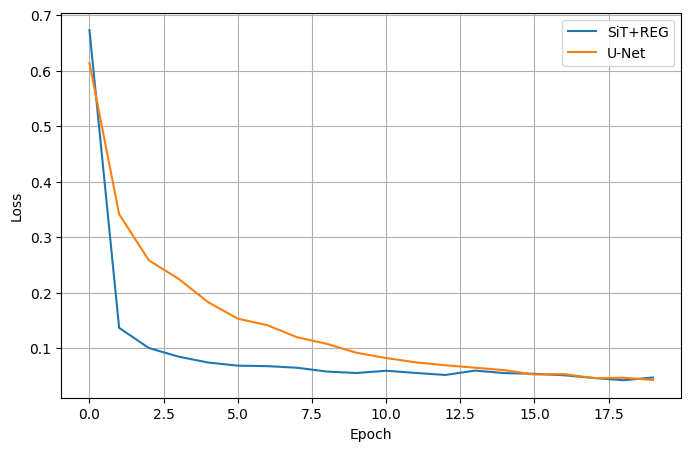

In [3]:
# Colab-ready single-file SiT + REG + U-Net pipeline (optimized for Colab T4)
# Usage: paste into a single Colab cell and run (Runtime: GPU)
# References:
# - Paper path (uploaded by you): /mnt/data/Research paper Diffusion Transformers.pdf

# ---------------------------
# 0) Install & imports
# ---------------------------
!pip install -q torch-fidelity einops tqdm
# (torch is preinstalled in Colab GPU runtime)

import os, math, random, shutil, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics

# Path to uploaded paper (for your reference)
PAPER_PATH = "/mnt/data/Research paper Diffusion Transformers.pdf"

# ---------------------------
# 1) Configuration (T4-friendly)
# ---------------------------
class Config:
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 32
    batch_size = 128               # T4-friendly for small model
    num_workers = 2

    # Latent / patch config (paper uses VAE latents; simpler small variant here)
    latent_hw = 8                  # 8 x 8 latent spatial (fits T4)
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2

    # SiT-small variant (downscaled)
    depth = 6
    hidden_dim = 256
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.1

    # Training
    timesteps = 250                # Paper uses 250 for evaluation; training also OK
    lr = 2e-4
    weight_decay = 1e-2
    betas = (0.9, 0.999)
    epochs = 20                    # increase for better quality
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_lambda = 0.03              # follow paper-ish small weight
    beta_cls = 0.03                # weight for class token v-prediction
    feat_dim = 256                 # class token dimension after vision proj
    align_layer = 2

    # Eval / output
    sample_n = 500                 # number of samples to generate for metrics (reduce if slow)
    out_dir = "./outputs_sit_reg_colab"
    ema_decay = 0.9999

cfg = Config()
os.makedirs(cfg.out_dir, exist_ok=True)
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
random.seed(cfg.seed)
device = cfg.device
print("Device:", device)
print("Paper file (for reference):", PAPER_PATH)

# ---------------------------
# 2) Noise scheduler (simple linear beta like DDPM but we use v-pred objective)
#    and helpers for v-target conversion
# ---------------------------
class Scheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        # linear beta from small to moderate
        self.betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1,0), value=1.0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.posterior_variance = self.betas * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)

    def sample_t(self, batch_size):
        return torch.randint(0, self.timesteps, (batch_size,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a = self.sqrt_alphas_cumprod[t].view(-1,1,1,1)
        b = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        return a * x0 + b * noise, noise

    def v_target(self, x0, eps):
        # For v-prediction used in many recent works, the target is epsilon (we use epsilon)
        return eps

scheduler = Scheduler(cfg.timesteps, device)

# ---------------------------
# 3) CIFAR-10 two-class subset loader
# ---------------------------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    class_to_idx = {n:i for i,n in enumerate(class_names)}
    target_idxs = {class_to_idx[c] for c in classes}
    transform = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=transform)
    indices = [i for i,(_,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True,
                        num_workers=cfg.num_workers, drop_last=True)

# ---------------------------
# 4) Lightweight VAE (encoder -> small latents; decoder -> reconstruct)
#    Paper uses strong pretrained VAE; for colab we'll train small VAE quickly
# ---------------------------
class SmallVAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        # encoder 32x32 -> 8x8
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 32->16
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 16->8
            nn.Conv2d(256, latent_channels, 3, 1, 1)
        )
        # decoder 8x8 -> 32x32
        self.dec = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1,1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 8->16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),  # 16->32
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

vae = SmallVAE().to(device)

# quick pretrain of VAE (small)
def pretrain_vae(epochs=3):
    opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
    vae.train()
    for ep in range(epochs):
        pbar = tqdm(dataloader, desc=f"VAE pretrain {ep+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            z = vae.encode(imgs)
            recon = vae.decode(z)
            loss = F.mse_loss(recon, imgs)
            opt.zero_grad()
            loss.backward()
            opt.step()
            pbar.set_postfix({'loss':f"{loss.item():.4f}"})
    print("VAE pretrain done")

pretrain_vae(epochs=2)  # brief pretraining

# ---------------------------
# 5) Sinusoidal timestep embedding
# ---------------------------
def get_timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(half, dtype=torch.float32, device=timesteps.device) / half)
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

# ---------------------------
# 6) Improved Transformer blocks (pre-norm), MultiHeadAttention
# ---------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.to_qkv = nn.Linear(dim, dim*3, bias=False)
        self.scale = (dim // heads) ** -0.5
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x):
        B,N,C = x.shape
        qkv = self.to_qkv(x).reshape(B,N,3,self.heads, C//self.heads).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1,2).reshape(B,N,C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, cfg.num_heads)
        self.norm2 = nn.LayerNorm(dim)
        mlp_dim = int(dim * cfg.mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# ---------------------------
# 7) SiT + REG model (downscaled)
# ---------------------------
class REGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim = cfg.hidden_dim
        self.patch_embed = nn.Linear(cfg.latent_patch_dim, cfg.hidden_dim)
        self.class_embed = nn.Linear(cfg.feat_dim, cfg.hidden_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, cfg.num_patches + 1, cfg.hidden_dim))
        self.time_mlp = nn.Sequential(
            nn.Linear(cfg.hidden_dim, cfg.hidden_dim*4),
            nn.SiLU(),
            nn.Linear(cfg.hidden_dim*4, cfg.hidden_dim)
        )
        self.blocks = nn.ModuleList([TransformerBlock(cfg.hidden_dim) for _ in range(cfg.depth)])
        self.norm = nn.LayerNorm(cfg.hidden_dim)
        self.patch_out = nn.Linear(cfg.hidden_dim, cfg.latent_patch_dim)
        self.cls_out = nn.Linear(cfg.hidden_dim, cfg.feat_dim)
        self.align_proj = nn.Linear(cfg.hidden_dim, cfg.feat_dim)  # maps hidden to feat space
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.zeros_(m.bias); nn.init.ones_(m.weight)

    def forward(self, z_patched, cls_token, t):
        B = z_patched.shape[0]
        patch_emb = self.patch_embed(z_patched)  # b, n, dim
        cls_emb = self.class_embed(cls_token).unsqueeze(1)  # b,1,dim
        x = torch.cat([cls_emb, patch_emb], dim=1)
        x = x + self.pos_embed
        t_emb = get_timestep_embedding(t, self.hidden_dim)
        t_emb = self.time_mlp(t_emb).unsqueeze(1)
        x = x + t_emb
        intermediate = None
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if i == cfg.align_layer:
                intermediate = x   # (B, N+1, hidden)
        x = self.norm(x)
        cls_pred = self.cls_out(x[:,0])
        patch_pred = self.patch_out(x[:,1:])
        hphi = self.align_proj(intermediate) if intermediate is not None else None
        return patch_pred, cls_pred, hphi

reg_sit = REGSiT().to(device)
print("REG SiT params:", sum(p.numel() for p in reg_sit.parameters()))

# ---------------------------
# 8) Vision foundation small extractor (simulate pretrained class token)
#    In the paper they use DINOv2; here we use a small frozen conv + linear to produce a class token.
# ---------------------------
class VisionFoundation(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3,64,3,2,1), nn.BatchNorm2d(64), nn.ReLU(),  # 32->16
            nn.Conv2d(64,128,3,2,1), nn.BatchNorm2d(128), nn.ReLU(), # 16->8
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(128, cfg.feat_dim)
        # we don't train this "foundation" to simulate frozen pre-trained model behavior
        for p in self.parameters():
            p.requires_grad = False

    def extract(self, x):
        B = x.shape[0]
        feats = self.backbone(x).view(B, -1)
        cls = F.normalize(self.proj(feats), dim=-1)
        # produce patch features placeholder (repeat cls across patches) for alignment targets
        patch_feats = cls.unsqueeze(1).repeat(1, cfg.num_patches, 1)
        return cls, patch_feats

vision = VisionFoundation().to(device)

# ---------------------------
# 9) REG training wrapper (computes loss)
# ---------------------------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision

    def forward(self, imgs, t):
        B = imgs.shape[0]
        # encode latents
        z_star = self.vae.encode(imgs)  # B, C, H, W (e.g. 4,8,8)
        # produce class token and patch targets
        cls_star, f_star = self.vision.extract(imgs)  # cls: B, feat_dim; f_star: B, num_patches, feat_dim
        # sample noises for both
        eps_z = torch.randn_like(z_star)
        eps_cls = torch.randn_like(cls_star)
        # add noise per scheduler
        zt, _ = scheduler.add_noise(z_star, t, noise=eps_z)
        # class token noising (use sqrt forms)
        a = scheduler.sqrt_alphas_cumprod[t].view(B,1)
        b = scheduler.sqrt_one_minus_alphas_cumprod[t].view(B,1)
        clst = a * cls_star + b * eps_cls

        # patchify zt: b c (h p) (w q) -> b (h w) (c p q)
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        # forward
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t)
        # reconstruct v_z shape
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        # v-targets (we use eps as target here for velocity pred)
        v_target_z = scheduler.v_target(z_star, eps_z)
        v_target_cls = scheduler.v_target(cls_star, eps_cls)

        # prediction loss (image + class token)
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.beta_cls * F.mse_loss(v_cls, v_target_cls)

        # alignment loss: align h_phi (projected) with y_star = concat(cls*, f*)
        loss_align = 0.0
        if h_phi is not None:
            # h_phi is B, N+1, feat_dim (our align_proj produced that)
            # y_star: concat cls*, f_star along token dim
            y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)  # B, N+1, feat_dim
            loss_align = F.mse_loss(h_phi, y_star.detach())

        total = loss_pred + cfg.reg_lambda * loss_align
        return total, loss_pred.item(), loss_align.item() if isinstance(loss_align, torch.Tensor) else float(loss_align)

reg_model = REGModel(reg_sit, vae, vision).to(device)

# ---------------------------
# 10) U-Net baseline (small)
# ---------------------------
class SmallUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim = 256
        self.time_embed = nn.Sequential(nn.Linear(self.time_dim, self.time_dim*4), nn.SiLU(), nn.Linear(self.time_dim*4, self.time_dim))
        self.enc1 = nn.Conv2d(cfg.latent_channels, 64, 3, 1,1)
        self.enc2 = nn.Conv2d(64,128,4,2,1)
        self.enc3 = nn.Conv2d(128,256,4,2,1)
        self.mid = nn.Conv2d(256,256,3,1,1)
        self.dec1 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec2 = nn.ConvTranspose2d(256,64,4,2,1)
        self.out = nn.Conv2d(128, cfg.latent_channels, 3,1,1)
        self.time_projs = nn.ModuleList([nn.Linear(self.time_dim,64), nn.Linear(self.time_dim,128), nn.Linear(self.time_dim,256), nn.Linear(self.time_dim,256), nn.Linear(self.time_dim,128), nn.Linear(self.time_dim,64)])

    def forward(self, x, t):
        B = x.shape[0]
        t_emb = get_timestep_embedding(t, self.time_dim)
        t_emb = self.time_embed(t_emb)
        x1 = F.silu(self.enc1(x) + self.time_projs[0](t_emb).view(B,64,1,1))
        x2 = F.silu(self.enc2(x1) + self.time_projs[1](t_emb).view(B,128,1,1))
        x3 = F.silu(self.enc3(x2) + self.time_projs[2](t_emb).view(B,256,1,1))
        m = F.silu(self.mid(x3) + self.time_projs[3](t_emb).view(B,256,1,1))
        d1 = F.silu(self.dec1(m) + self.time_projs[4](t_emb).view(B,128,1,1))
        d1 = torch.cat([d1, x2], dim=1)
        d2 = F.silu(self.dec2(d1) + self.time_projs[5](t_emb).view(B,64,1,1))
        d2 = torch.cat([d2, x1], dim=1)
        out = self.out(d2)
        return out

unet = SmallUNet().to(device)

# ---------------------------
# 11) Optimizers & EMA & AMP
# ---------------------------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)

# EMA wrappers
def make_ema(model):
    ema = {}
    for name, p in model.named_parameters():
        if p.requires_grad:
            ema[name] = p.detach().cpu().clone()
    return ema

def load_ema_to_model(model, ema):
    for name, p in model.named_parameters():
        if name in ema:
            p.data.copy_(ema[name].to(p.device))

def update_ema(model, ema, decay):
    for name, p in model.named_parameters():
        if name in ema:
            ema[name].mul_(decay).add_(p.detach().cpu(), alpha=1.0-decay)

ema_reg = make_ema(reg_model)
ema_unet = make_ema(unet)

scaler = torch.cuda.amp.GradScaler()

# ---------------------------
# 12) Training loops
# ---------------------------
reg_loss_history, unet_loss_history = [], []

def train_reg(epochs):
    reg_model.train()
    for ep in range(epochs):
        total = 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {ep+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            t = scheduler.sample_t(imgs.shape[0])
            with torch.cuda.amp.autocast():
                loss, lp, la = reg_model(imgs, t)
            opt_reg.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_reg)
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            scaler.step(opt_reg)
            scaler.update()
            update_ema(reg_model, ema_reg, cfg.ema_decay)
            total += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'pred':f"{lp:.4f}", 'align':f"{la:.4f}"})
        avg = total / len(dataloader)
        reg_loss_history.append(avg)
        print(f"REG Epoch {ep+1} avg: {avg:.4f}")

def train_unet(epochs):
    unet.train()
    for ep in range(epochs):
        total = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {ep+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            # encode z_star no grad for unet training
            with torch.no_grad():
                z_star = vae.encode(imgs)
            t = scheduler.sample_t(B)
            eps = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t, noise=eps)
            with torch.cuda.amp.autocast():
                v_pred = unet(zt, t)
                loss = F.mse_loss(v_pred, eps)
            opt_unet.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_unet)
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            scaler.step(opt_unet)
            scaler.update()
            update_ema(unet, ema_unet, cfg.ema_decay)
            total += loss.item()
            pbar.set_postfix({'loss':f"{loss.item():.4f}"})
        avg = total / len(dataloader)
        unet_loss_history.append(avg)
        print(f"UNet Epoch {ep+1} avg: {avg:.4f}")

# ---------------------------
# 13) Sampling (Euler-Maruyama style / v-prediction)
# ---------------------------
@torch.no_grad()
def sample_unet(num_samples, batch_size=32):
    parts = []
    for i in range(0, num_samples, batch_size):
        b = min(batch_size, num_samples-i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        # use EMA weights for unet
        unet_saved = {n:p.detach().cpu().clone() for n,p in unet.named_parameters() if p.requires_grad}
        load_ema_to_model(unet, ema_unet)
        for i_t in tqdm(range(cfg.timesteps-1, -1, -1), desc="U-Net Sampling", leave=False):
            t = torch.full((b,), i_t, device=device, dtype=torch.long)
            eps_pred = unet(z, t)
            alpha = scheduler.alphas[t].view(-1,1,1,1)
            alpha_cum = scheduler.alpha_cumprod[t].view(-1,1,1,1)
            if i_t>0:
                noise = torch.randn_like(z)
            else:
                noise = 0
            z = (1/torch.sqrt(alpha))*( z - ((1-alpha)/torch.sqrt(1-alpha_cum))*eps_pred ) + torch.sqrt(scheduler.posterior_variance[t]).view(-1,1,1,1)*noise
        imgs = vae.decode(z)
        parts.append(torch.clamp((imgs+1)/2,0,1).cpu())
        # restore unet weights
        load_ema_to_model(unet, ema_unet)
    return torch.cat(parts, dim=0)

@torch.no_grad()
def sample_reg(num_samples, batch_size=32):
    parts=[]
    # create starting z and class prior
    for i in range(0, num_samples, batch_size):
        b = min(batch_size, num_samples-i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        cls_prior = torch.randn(b, cfg.feat_dim, device=device)
        # use EMA weights for sit
        sit_saved = {n:p.detach().cpu().clone() for n,p in reg_sit.named_parameters() if p.requires_grad}
        # load ema into sit
        load_ema_to_model(reg_sit, ema_reg)
        for i_t in tqdm(range(cfg.timesteps-1, -1, -1), desc="REG Sampling", leave=False):
            t = torch.full((b,), i_t, device=device, dtype=torch.long)
            # prepare patches
            z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                                  p=cfg.patch_size, q=cfg.patch_size,
                                  h=cfg.latent_hw//cfg.patch_size,
                                  w=cfg.latent_hw//cfg.patch_size)
            v_patch, v_cls, _ = reg_sit(z_patched, cls_prior, t)
            v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                            p=cfg.patch_size, q=cfg.patch_size,
                            h=cfg.latent_hw//cfg.patch_size,
                            w=cfg.latent_hw//cfg.patch_size,
                            c=cfg.latent_channels)
            alpha = scheduler.alphas[t].view(-1,1,1,1)
            alpha_cum = scheduler.alpha_cumprod[t].view(-1,1,1,1)
            if i_t>0:
                noise = torch.randn_like(z)
            else:
                noise = 0
            z = (1/torch.sqrt(alpha))*( z - ((1-alpha)/torch.sqrt(1-alpha_cum))*v_z ) + torch.sqrt(scheduler.posterior_variance[t]).view(-1,1,1,1)*noise
            # update class token (small step)
            cls_prior = cls_prior - 0.01 * v_cls
        imgs = vae.decode(z)
        parts.append(torch.clamp((imgs+1)/2,0,1).cpu())
        # restore sit weights from EMA (we used EMA already)
    return torch.cat(parts, dim=0)

def save_grid(imgs, path, nrow=10):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)

# ---------------------------
# 14) Metrics evaluation (torch-fidelity)
# ---------------------------
def evaluate_models(num_samples=cfg.sample_n):
    results = {}
    real_path = os.path.join(cfg.out_dir, "real_images")
    if os.path.exists(real_path): shutil.rmtree(real_path)
    os.makedirs(real_path, exist_ok=True)
    # gather real images
    cnt=0
    for imgs,_ in dataloader:
        for im in imgs:
            torchvision.utils.save_image((im+1)/2, os.path.join(real_path, f"{cnt:05d}.png"))
            cnt+=1
            if cnt>=num_samples:
                break
        if cnt>=num_samples: break

    for model_type in ['reg','unet']:
        print(f"\nGenerating samples for {model_type.upper()}...")
        if model_type=='reg':
            gen = sample_reg(num_samples, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, 'reg_samples.png'), nrow=10)
        else:
            gen = sample_unet(num_samples, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, 'unet_samples.png'), nrow=10)

        gen_path = os.path.join(cfg.out_dir, f"{model_type}_eval")
        if os.path.exists(gen_path): shutil.rmtree(gen_path)
        os.makedirs(gen_path, exist_ok=True)
        for i, img in enumerate(gen):
            torchvision.utils.save_image(img, os.path.join(gen_path, f"{i:05d}.png"))
        print("Calculating metrics (this may take a bit)...")
        try:
            metrics = calculate_metrics(input1=gen_path, input2=real_path, cuda=torch.cuda.is_available(), isc=True, fid=True, kid=False, verbose=False)
            results[model_type] = metrics
            print(f"{model_type.upper()} Metrics: FID={metrics['frechet_inception_distance']:.2f}, IS={metrics['inception_score_mean']:.2f}")
        except Exception as e:
            print("Metric computation error:", e)
            results[model_type] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}
    return results

# ---------------------------
# 15) Plot helper
# ---------------------------
def plot_loss():
    plt.figure(figsize=(8,5))
    if reg_loss_history: plt.plot(reg_loss_history, label='SiT+REG')
    if unet_loss_history: plt.plot(unet_loss_history, label='U-Net')
    plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True)
    plt.savefig(os.path.join(cfg.out_dir,"loss.png"), dpi=200)

# ---------------------------
# 16) Main execution
# ---------------------------
if __name__ == "__main__":
    print("="*50)
    print("Starting training (SiT+REG and U-Net baseline) on Colab T4 friendly config")
    print("="*50)
    # TRAIN
    train_reg(cfg.epochs)
    train_unet(cfg.epochs)
    # Save losses
    plot_loss()
    # Evaluate and compute FID/IS
    print("\n" + "="*40)
    print(f"Evaluating on {cfg.sample_n} samples")
    print("="*40)
    metrics = evaluate_models(cfg.sample_n)
    print("\nFINAL RESULTS:")
    for m,met in metrics.items():
        fid = met.get('frechet_inception_distance', float('inf'))
        is_ = met.get('inception_score_mean', 0.0)
        print(f"{m.upper():<8} | FID: {fid:8.2f} | IS: {is_:6.2f}")
    print("Done! Check", cfg.out_dir, "for outputs (images, loss plot).")


In [ ]:
# Updated SiT+REG + U-Net script (Colab T4-friendly)
# - Uses v-prediction, Euler-Maruyama sampling, REG entanglement, EMA, CFG
# - Based on "Representation Entanglement for Generation" (see citations above)

# NOTE: run in a single cell. Install dependencies first in Colab if needed:
# !pip install torch-fidelity einops --upgrade -q

import os
import math
import random
import shutil
from pathlib import Path
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# For FID/IS
from torch_fidelity import calculate_metrics

# -------------------------
# CONFIG (edit for memory/batch)
# -------------------------
class CFG:
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 32
    batch_size = 128             # T4 friendly: try 128; if OOM reduce to 64
    num_workers = 2

    latent_hw = 8
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2

    # SiT architecture (small)
    depth = 6
    hidden_dim = 256
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.1

    # Training (paper recommends AdamW 1e-4, batch 256; scaled here)
    timesteps = 250              # paper uses 250 sampling steps for evaluation. Use same for sampling.
    lr = 1e-4
    weight_decay = 1e-3
    betas = (0.9, 0.999)
    epochs = 20
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params from paper: β and λ (scaled / kept same intent)
    reg_beta = 0.03
    reg_lambda = 0.5
    feat_dim = 256
    align_layer = 4               # paper aligns at layer 4 for SiT-B/2
    sample_n = 500
    out_dir = "./outputs_reg_fixed"
    ema_decay = 0.9999
    cfg_guidance_scale = 2.0      # default CFG; you can tune (paper uses CFG w up to 4)

cfg = CFG()
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = cfg.device
os.makedirs(cfg.out_dir, exist_ok=True)
print("Device:", device)

# -------------------------
# Noise / interpolant schedule (paper uses α_t = 1-t, σ_t = t in a normalized [0,1] time)
# We'll map discrete t in [0, timesteps-1] to continuous τ in [0,1].
# -------------------------
class PaperScheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        # continuous time tau = t / (T-1), alpha(tau)=1-tau, sigma(tau)=tau
        taus = torch.linspace(0.0, 1.0, timesteps, device=self.device)
        self.alpha = (1.0 - taus).to(device)
        self.sigma = taus.to(device)
        # helper terms for v-prediction mapping (for v-target = epsilon)
        self.sqrt_alpha = torch.sqrt(self.alpha).to(device)
        self.sqrt_one_minus_alpha = torch.sqrt(1.0 - self.alpha).to(device)
    def sample_t(self, batch):
        return torch.randint(0, self.timesteps, (batch,), device=self.device, dtype=torch.long)
    def add_noise(self, x0, t, noise=None):
        # returns x_t and noise
        if noise is None:
            noise = torch.randn_like(x0)
        a = self.alpha[t].view(-1,1,1,1)
        s = self.sigma[t].view(-1,1,1,1)
        return a * x0 + s * noise, noise
    def to_cont(self, t):
        return t / (self.timesteps - 1)

scheduler = PaperScheduler(cfg.timesteps, device)

# -------------------------
# Data
# -------------------------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    class_to_idx = {n:i for i,n in enumerate(class_names)}
    target_idxs = {class_to_idx[c] for c in classes}
    transform = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))   # map in [-1,1] for VAE tanh decoder
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=transform)
    indices = [i for i,(x,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True,
                        num_workers=cfg.num_workers, drop_last=True)

# -------------------------
# Small VAE (encoder->latent_hw x latent_hw -> decoder)
# -------------------------
class SmallVAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),  # 32->16
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), # 16->8
            nn.Conv2d(256, latent_channels, 3, 1, 1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(), # 8->16
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),  # 16->32
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )
    def encode(self, x): return self.encoder(x)
    def decode(self, z): return self.decoder(z)

vae = SmallVAE().to(device)

# Quick VAE warmup like you did (3 epochs)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
vae.train()
print("Pretraining VAE (2 epochs)...")
for ep in range(2):
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        z = vae.encode(imgs)
        recon = vae.decode(z)
        loss = F.mse_loss(recon, imgs)
        vae_opt.zero_grad(); loss.backward(); vae_opt.step()
print("VAE warmup done")

# -------------------------
# Small SiT (REG) and Vision foundation
# -------------------------
class MHA(nn.Module):
    def __init__(self, dim, heads=cfg.num_heads):
        super().__init__()
        self.heads = heads
        self.to_qkv = nn.Linear(dim, dim*3, bias=False)
        self.scale = (dim//heads)**-0.5
        self.to_out = nn.Linear(dim, dim)
    def forward(self, x):
        B,N,C = x.shape
        qkv = self.to_qkv(x).view(B,N,3,self.heads,C//self.heads).permute(2,0,3,1,4)
        q,k,v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1,2).reshape(B,N,C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = MHA(dim)
        self.ln2 = nn.LayerNorm(dim)
        mlp_dim = int(dim * cfg.mlp_ratio)
        self.mlp = nn.Sequential(nn.Linear(dim, mlp_dim), nn.GELU(), nn.Linear(mlp_dim, dim))
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class REGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        Dp = cfg.latent_patch_dim
        Hd = cfg.hidden_dim
        self.patch_embed = nn.Linear(Dp, Hd)
        self.class_embed = nn.Linear(cfg.feat_dim, Hd)
        self.pos = nn.Parameter(torch.zeros(1, cfg.num_patches+1, Hd))
        self.time_mlp = nn.Sequential(nn.Linear(Hd, Hd*4), nn.SiLU(), nn.Linear(Hd*4, Hd))
        self.blocks = nn.ModuleList([TransformerBlock(Hd) for _ in range(cfg.depth)])
        self.norm = nn.LayerNorm(Hd)
        self.patch_out = nn.Linear(Hd, Dp)
        self.cls_out = nn.Linear(Hd, cfg.feat_dim)
        self.align_proj = nn.Linear(Hd, cfg.feat_dim)
        self.apply(self._init_weights)
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None: nn.init.constant_(m.bias, 0.)
    def forward(self, z_patched, cls_token, t):
        B = z_patched.shape[0]
        patch_emb = self.patch_embed(z_patched)
        cls_emb = self.class_embed(cls_token).unsqueeze(1)
        x = torch.cat([cls_emb, patch_emb], dim=1) + self.pos
        # timestep embedding (simple)
        t_emb = get_timestep_embedding(t, cfg.hidden_dim).to(x.device)
        t_emb = self.time_mlp(t_emb).unsqueeze(1)
        x = x + t_emb
        inter = None
        for i, b in enumerate(self.blocks):
            x = b(x)
            if i == cfg.align_layer:
                inter = x
        x = self.norm(x)
        cls_pred = self.cls_out(x[:,0])
        patch_pred = self.patch_out(x[:,1:])
        h_phi = self.align_proj(inter) if inter is not None else None
        return patch_pred, cls_pred, h_phi

def get_timestep_embedding(timesteps, dim, max_period=10000):
    # sinusoidal embedding (standard)
    half = dim//2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, dtype=torch.float32) / half).to(device)
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

reg_sit = REGSiT().to(device)

# Vision foundation: small CNN producing class token + dense patch features
class SmallVision(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3,64,3,2,1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,2,1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(128, cfg.feat_dim)
    def extract(self, x):
        B = x.shape[0]
        f = self.backbone(x).view(B,-1)
        feat = F.normalize(self.proj(f), dim=-1)
        cls = feat
        patch = feat.unsqueeze(1).repeat(1, cfg.num_patches, 1)
        return cls, patch

vision = SmallVision().to(device)

# -------------------------
# REG model wrapper computing loss (v-pred + alignment)
# -------------------------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision
    def forward(self, imgs, t_idx):
        B = imgs.shape[0]
        z_star = self.vae.encode(imgs)              # z*: (B,C,H,W)
        cls_star, dense_star = self.vision.extract(imgs)  # cls_star: (B,feat_dim)
        # sample noises
        eps_z = torch.randn_like(z_star)
        eps_cls = torch.randn_like(cls_star)
        # add noise using paper schedule (alpha/sigma)
        zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps_z)
        a = scheduler.alpha[t_idx].view(B,1)
        s = scheduler.sigma[t_idx].view(B,1)
        clst = (a * cls_star + s * eps_cls)
        # patchify zt
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        # forward sit
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_idx)
        # reconstruct v_z spatial
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        # v-targets (paper uses v-target = epsilon)  
        v_target_z = eps_z
        v_target_cls = eps_cls
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.reg_beta * F.mse_loss(v_cls, v_target_cls)
        loss_align = 0.0
        if h_phi is not None:
            # make y_star: concat cls and dense features (paper aligns to this)
            y_star = torch.cat([cls_star.unsqueeze(1), dense_star], dim=1)
            loss_align = F.mse_loss(h_phi, y_star.detach())
        total_loss = loss_pred + cfg.reg_lambda * loss_align
        # returning components for logging
        return total_loss, loss_pred.detach().item(), loss_align if isinstance(loss_align, torch.Tensor) else torch.tensor(loss_align)

reg_model = REGModel(reg_sit, vae, vision).to(device)

# -------------------------
# Small U-Net baseline (v-pred)
# -------------------------
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim = 256
        self.time_mlp = nn.Sequential(nn.Linear(self.time_dim, self.time_dim*4), nn.SiLU(), nn.Linear(self.time_dim*4, self.time_dim))
        self.enc1 = nn.Conv2d(cfg.latent_channels, 64, 3, 1,1)
        self.enc2 = nn.Conv2d(64,128,4,2,1)
        self.enc3 = nn.Conv2d(128,256,4,2,1)
        self.mid = nn.Conv2d(256,256,3,1,1)
        self.dec1 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec2 = nn.ConvTranspose2d(256,64,4,2,1)
        self.out = nn.Conv2d(128, cfg.latent_channels, 3,1,1)
        self.timings = nn.ModuleList([nn.Linear(self.time_dim, k) for k in (64,128,256,256,128,64)])
    def forward(self, x, t):
        B=x.shape[0]
        t_emb = get_timestep_embedding(t, self.time_dim).to(x.device)
        t_emb = self.time_mlp(t_emb)
        x1 = F.silu(self.enc1(x) + self.timings[0](t_emb).view(B,64,1,1))
        x2 = F.silu(self.enc2(x1) + self.timings[1](t_emb).view(B,128,1,1))
        x3 = F.silu(self.enc3(x2) + self.timings[2](t_emb).view(B,256,1,1))
        m = F.silu(self.mid(x3) + self.timings[3](t_emb).view(B,256,1,1))
        d1 = F.silu(self.dec1(m) + self.timings[4](t_emb).view(B,128,1,1))
        d1 = torch.cat([d1, x2], dim=1)
        d2 = F.silu(self.dec2(d1) + self.timings[5](t_emb).view(B,64,1,1))
        d2 = torch.cat([d2, x1], dim=1)
        out = self.out(d2)
        return out

unet = SimpleUNet().to(device)

# -------------------------
# Optimizers, EMA, schedulers
# -------------------------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr, betas=cfg.betas, weight_decay=cfg.weight_decay)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr, betas=cfg.betas, weight_decay=cfg.weight_decay)
sched_reg = torch.optim.lr_scheduler.CosineAnnealingLR(opt_reg, T_max=cfg.epochs)
sched_unet = torch.optim.lr_scheduler.CosineAnnealingLR(opt_unet, T_max=cfg.epochs)

class EMA:
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
    def update(self, model):
        for k,v in model.state_dict().items():
            self.shadow[k] = (self.decay * self.shadow[k] + (1.0-self.decay) * v.detach().cpu()).clone()
    def apply_to(self, model):
        model.load_state_dict({k: self.shadow[k].to(next(model.parameters()).device) for k in model.state_dict().keys()})

ema_reg = EMA(reg_model, cfg.ema_decay)
ema_unet = EMA(unet, cfg.ema_decay)

# -------------------------
# Training loops (use AMP)
# -------------------------
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def train_reg(epochs):
    reg_model.train()
    for epoch in range(epochs):
        total, total_pred, total_align = 0.0, 0.0, 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            t_idx = scheduler.sample_t(B)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                loss, loss_pred, loss_align = reg_model(imgs, t_idx)
            opt_reg.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_reg)
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            scaler.step(opt_reg)
            scaler.update()
            ema_reg.update(reg_model)
            total += loss.item()
            total_pred += loss_pred
            total_align += (loss_align.item() if isinstance(loss_align, torch.Tensor) else float(loss_align))
            pbar.set_postfix({'loss':f'{loss.item():.4f}','pred':f'{loss_pred:.4f}','align':f'{(loss_align.item() if isinstance(loss_align, torch.Tensor) else float(loss_align)):.4f}'})
        sched_reg.step()
        print(f"REG Epoch {epoch+1} avg: {total/len(dataloader):.4f}")
        # save checkpoint occasionally
        torch.save({'epoch':epoch+1, 'model':reg_model.state_dict(), 'opt':opt_reg.state_dict()}, os.path.join(cfg.out_dir, f"reg_epoch_{epoch+1}.pt"))

def train_unet(epochs):
    unet.train()
    for epoch in range(epochs):
        total = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {epoch+1}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            with torch.no_grad():
                z_star = vae.encode(imgs)
            t_idx = scheduler.sample_t(B)
            eps = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                v_pred = unet(zt, t_idx)
                loss = F.mse_loss(v_pred, eps)   # v-pred target epsilon
            opt_unet.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_unet)
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            scaler.step(opt_unet)
            scaler.update()
            ema_unet.update(unet)
            total += loss.item()
            pbar.set_postfix({'loss':f'{loss.item():.4f}'})
        sched_unet.step()
        print(f"UNet Epoch {epoch+1} avg: {total/len(dataloader):.4f}")
        torch.save({'epoch':epoch+1, 'model':unet.state_dict(), 'opt':opt_unet.state_dict()}, os.path.join(cfg.out_dir, f"unet_epoch_{epoch+1}.pt"))

# -------------------------
# Euler-Maruyama sampler for v-pred (paper) with CFG for REG
# (Reference: Table 12 and sampler description). :contentReference[oaicite:9]{index=9}
# -------------------------
@torch.no_grad()
def em_step_v(z, v_pred, t_idx, t_prev_idx):
    # z: current latent; v_pred: predicted v (epsilon) at time t
    # follow discrete Euler-Maruyama reverse update for v-pred (paper formulation)
    alpha_t = scheduler.alpha[t_idx].view(-1,1,1,1)
    sigma_t = scheduler.sigma[t_idx].view(-1,1,1,1)
    alpha_prev = scheduler.alpha[t_prev_idx].view(-1,1,1,1)
    sigma_prev = scheduler.sigma[t_prev_idx].view(-1,1,1,1)
    # Use v-pred to estimate clean x0: x0_hat = (z - sigma_t * v_pred) / alpha_t
    x0_hat = (z - sigma_t * v_pred) / (alpha_t + 1e-12)
    # deterministic prediction for next z_prev (Euler-Maruyama reverse)
    # using discrete form: z_prev = alpha_prev * x0_hat + sigma_prev * noise
    if (t_prev_idx==t_idx).all():
        # last step (t=0)
        return alpha_prev * x0_hat
    noise = torch.randn_like(z)
    z_prev = alpha_prev * x0_hat + sigma_prev * noise
    return z_prev

@torch.no_grad()
def sample_unet(num_samples):
    B = num_samples
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    for i in tqdm(range(cfg.timesteps-1, -1, -1), desc="UNet Sampling"):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        v = unet(z, t)
        t_prev = torch.clamp(t-1, min=0)
        z = em_step_v(z, v, t, t_prev)
    imgs = vae.decode(z)
    return torch.clamp((imgs + 1)/2, 0, 1)

@torch.no_grad()
def sample_reg(num_samples, cfg_guidance=1.0):
    B = num_samples
    # z prior and class prior
    z = torch.randn(B, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
    cls = torch.randn(B, cfg.feat_dim, device=device)
    for i in tqdm(range(cfg.timesteps-1, -1, -1), desc="REG Sampling"):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        # patchify z
        z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        # Predict velocity (v) for both patches and class token
        v_patch, v_cls, _ = reg_sit(z_patched, cls, t)
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        # apply classifier-free guidance on class token: amplify v_cls
        v_cls = v_cls * cfg_guidance
        t_prev = torch.clamp(t-1, min=0)
        z = em_step_v(z, v_z, t, t_prev)
        # update class token by small gradient-step-like update (paper used a small update)
        cls = cls - 0.01 * v_cls
    imgs = vae.decode(z)
    return torch.clamp((imgs + 1)/2, 0, 1)

# -------------------------
# Evaluation utilities
# -------------------------
def save_grid(imgs, path, nrow=10):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)
def evaluate_models(num_samples=cfg.sample_n):
    results = {}
    # prepare real images set
    real_path = os.path.join(cfg.out_dir, f"real_{num_samples}")
    if os.path.exists(real_path): shutil.rmtree(real_path)
    os.makedirs(real_path, exist_ok=True)
    cnt = 0
    for imgs,_ in dataloader:
        for im in imgs:
            torchvision.utils.save_image((im+1)/2, os.path.join(real_path, f"{cnt:05d}.png"))
            cnt += 1
            if cnt >= num_samples: break
        if cnt >= num_samples: break

    for model_type in ['reg', 'unet']:
        print(f"\nGenerating samples for {model_type.upper()}...")
        if model_type == 'reg':
            imgs = sample_reg(num_samples, cfg_guidance=cfg.cfg_guidance_scale)
            save_grid(imgs, os.path.join(cfg.out_dir, 'reg_samples.png'), nrow=10)
        else:
            imgs = sample_unet(num_samples)
            save_grid(imgs, os.path.join(cfg.out_dir, 'unet_samples.png'), nrow=10)

        gen_path = os.path.join(cfg.out_dir, f"{model_type}_eval_{num_samples}")
        if os.path.exists(gen_path): shutil.rmtree(gen_path)
        os.makedirs(gen_path, exist_ok=True)
        for i,img in enumerate(imgs):
            torchvision.utils.save_image(img, os.path.join(gen_path, f"{i:05d}.png"))

        print(f"Calculating metrics for {model_type.upper()}...")
        try:
            metrics = calculate_metrics(input1=gen_path, input2=real_path, cuda=torch.cuda.is_available(), isc=True, fid=True, kid=False, verbose=False)
            results[model_type] = metrics
            print(f"{model_type.upper()} Metrics: FID={metrics['frechet_inception_distance']:.2f}, IS={metrics['inception_score_mean']:.2f}")
        except Exception as e:
            print("Metric calc error:", e)
            results[model_type] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}
    return results

# -------------------------
# Main run: train both, then evaluate
# -------------------------
if __name__ == "__main__":
    print("="*50)
    print("Starting training (REG + U-Net) - uses v-pred, REG entanglement, EMA, CFG")
    print("="*50)
    train_reg(cfg.epochs)
    train_unet(cfg.epochs)
    # apply EMA weights before sampling
    print("Applying EMA to models for sampling...")
    ema_reg.apply_to(reg_model)
    ema_unet.apply_to(unet)
    print("Evaluating samples...")
    results = evaluate_models()
    print("FINAL RESULTS:")
    for k,m in results.items():
        print(f"{k.upper():<8} | FID: {m.get('frechet_inception_distance', float('inf')):.2f} | IS: {m.get('inception_score_mean',0.0):.2f}")
    print("Done. Check", cfg.out_dir)


Device: cuda
Loaded 10000 images (['cat', 'dog'])
Pretraining VAE (2 epochs)...


/tmp/ipython-input-967729455.py:379: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


VAE warmup done
Starting training (REG + U-Net) - uses v-pred, REG entanglement, EMA, CFG


REG Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-967729455.py:390: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
REG Epoch 1/20: 100%|██████████| 78/78 [00:08<00:00,  9.42it/s, loss=0.4121, pred=0.3191, align=0.1859]


REG Epoch 1 avg: 0.9735


REG Epoch 2/20: 100%|██████████| 78/78 [00:07<00:00, 10.21it/s, loss=0.3192, pred=0.2473, align=0.1437]


REG Epoch 2 avg: 0.3498


REG Epoch 3/20: 100%|██████████| 78/78 [00:08<00:00,  9.29it/s, loss=0.2848, pred=0.2228, align=0.1240]


REG Epoch 3 avg: 0.2833


REG Epoch 4/20: 100%|██████████| 78/78 [00:08<00:00,  9.62it/s, loss=0.2220, pred=0.1698, align=0.1044]


REG Epoch 4 avg: 0.2371


REG Epoch 5/20: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s, loss=0.1893, pred=0.1427, align=0.0932]


REG Epoch 5 avg: 0.2056


REG Epoch 6/20: 100%|██████████| 78/78 [00:08<00:00,  9.26it/s, loss=0.1512, pred=0.1091, align=0.0843]


REG Epoch 6 avg: 0.1810


REG Epoch 7/20: 100%|██████████| 78/78 [00:07<00:00,  9.91it/s, loss=0.1803, pred=0.1421, align=0.0763]


REG Epoch 7 avg: 0.1714


REG Epoch 8/20: 100%|██████████| 78/78 [00:08<00:00,  9.08it/s, loss=0.1372, pred=0.1031, align=0.0682]


REG Epoch 8 avg: 0.1549


REG Epoch 9/20: 100%|██████████| 78/78 [00:08<00:00,  9.36it/s, loss=0.1410, pred=0.1071, align=0.0678]


REG Epoch 9 avg: 0.1325


REG Epoch 10/20: 100%|██████████| 78/78 [00:07<00:00, 10.00it/s, loss=0.1168, pred=0.0900, align=0.0535]


REG Epoch 10 avg: 0.1190


REG Epoch 11/20: 100%|██████████| 78/78 [00:07<00:00,  9.84it/s, loss=0.1099, pred=0.0864, align=0.0469]


REG Epoch 11 avg: 0.1112


REG Epoch 12/20: 100%|██████████| 78/78 [00:08<00:00,  9.44it/s, loss=0.1044, pred=0.0842, align=0.0404]


REG Epoch 12 avg: 0.0988


REG Epoch 13/20: 100%|██████████| 78/78 [00:07<00:00, 10.47it/s, loss=0.0741, pred=0.0546, align=0.0391]


REG Epoch 13 avg: 0.0926


REG Epoch 14/20: 100%|██████████| 78/78 [00:08<00:00,  9.44it/s, loss=0.0789, pred=0.0604, align=0.0370]


REG Epoch 14 avg: 0.0862


REG Epoch 15/20: 100%|██████████| 78/78 [00:08<00:00,  9.39it/s, loss=0.0845, pred=0.0674, align=0.0343]


REG Epoch 15 avg: 0.0809


REG Epoch 16/20: 100%|██████████| 78/78 [00:07<00:00, 10.47it/s, loss=0.0776, pred=0.0615, align=0.0322]


REG Epoch 16 avg: 0.0785


REG Epoch 17/20: 100%|██████████| 78/78 [00:08<00:00,  9.30it/s, loss=0.0910, pred=0.0749, align=0.0321]


REG Epoch 17 avg: 0.0740


REG Epoch 18/20: 100%|██████████| 78/78 [00:08<00:00,  9.53it/s, loss=0.0866, pred=0.0698, align=0.0336]


REG Epoch 18 avg: 0.0723


REG Epoch 19/20: 100%|██████████| 78/78 [00:07<00:00, 10.43it/s, loss=0.0684, pred=0.0524, align=0.0320]


REG Epoch 19 avg: 0.0705


REG Epoch 20/20: 100%|██████████| 78/78 [00:08<00:00,  9.46it/s, loss=0.0847, pred=0.0697, align=0.0300]


REG Epoch 20 avg: 0.0694


UNet Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-967729455.py:421: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
UNet Epoch 1/20: 100%|██████████| 78/78 [00:04<00:00, 17.27it/s, loss=0.5872]


UNet Epoch 1 avg: 0.7945


UNet Epoch 2/20: 100%|██████████| 78/78 [00:05<00:00, 14.33it/s, loss=0.4622]


UNet Epoch 2 avg: 0.5019


UNet Epoch 3/20: 100%|██████████| 78/78 [00:04<00:00, 17.32it/s, loss=0.3626]


UNet Epoch 3 avg: 0.4041


UNet Epoch 4/20: 100%|██████████| 78/78 [00:04<00:00, 17.08it/s, loss=0.3482]


UNet Epoch 4 avg: 0.3583


UNet Epoch 5/20: 100%|██████████| 78/78 [00:05<00:00, 14.30it/s, loss=0.2742]


UNet Epoch 5 avg: 0.3115


UNet Epoch 6/20: 100%|██████████| 78/78 [00:04<00:00, 17.12it/s, loss=0.2675]


UNet Epoch 6 avg: 0.2831


UNet Epoch 7/20: 100%|██████████| 78/78 [00:04<00:00, 15.64it/s, loss=0.2549]


UNet Epoch 7 avg: 0.2641


UNet Epoch 8/20: 100%|██████████| 78/78 [00:04<00:00, 15.98it/s, loss=0.2359]


UNet Epoch 8 avg: 0.2408


UNet Epoch 9/20: 100%|██████████| 78/78 [00:04<00:00, 17.34it/s, loss=0.2367]


UNet Epoch 9 avg: 0.2260


UNet Epoch 10/20: 100%|██████████| 78/78 [00:05<00:00, 14.11it/s, loss=0.2009]


UNet Epoch 10 avg: 0.2052


UNet Epoch 11/20: 100%|██████████| 78/78 [00:04<00:00, 17.51it/s, loss=0.2212]


UNet Epoch 11 avg: 0.1920


UNet Epoch 12/20: 100%|██████████| 78/78 [00:04<00:00, 17.20it/s, loss=0.1610]


UNet Epoch 12 avg: 0.1843


UNet Epoch 13/20: 100%|██████████| 78/78 [00:05<00:00, 14.44it/s, loss=0.1645]


UNet Epoch 13 avg: 0.1770


UNet Epoch 14/20: 100%|██████████| 78/78 [00:04<00:00, 17.55it/s, loss=0.1602]


UNet Epoch 14 avg: 0.1751


UNet Epoch 15/20: 100%|██████████| 78/78 [00:05<00:00, 15.32it/s, loss=0.1665]


UNet Epoch 15 avg: 0.1715


UNet Epoch 16/20: 100%|██████████| 78/78 [00:04<00:00, 16.11it/s, loss=0.1724]


UNet Epoch 16 avg: 0.1611


UNet Epoch 17/20: 100%|██████████| 78/78 [00:04<00:00, 17.40it/s, loss=0.2104]


UNet Epoch 17 avg: 0.1659


UNet Epoch 18/20: 100%|██████████| 78/78 [00:05<00:00, 14.30it/s, loss=0.1440]


UNet Epoch 18 avg: 0.1572


UNet Epoch 19/20: 100%|██████████| 78/78 [00:04<00:00, 17.31it/s, loss=0.1420]


UNet Epoch 19 avg: 0.1629


UNet Epoch 20/20: 100%|██████████| 78/78 [00:04<00:00, 17.05it/s, loss=0.1674]


UNet Epoch 20 avg: 0.1617
Applying EMA to models for sampling...
Evaluating samples...

Generating samples for REG...


REG Sampling: 100%|██████████| 250/250 [00:10<00:00, 24.00it/s]


Calculating metrics for REG...
REG Metrics: FID=385.44, IS=1.86

Generating samples for UNET...


UNet Sampling: 100%|██████████| 250/250 [00:03<00:00, 77.11it/s]


Calculating metrics for UNET...
UNET Metrics: FID=440.39, IS=1.89
FINAL RESULTS:
REG      | FID: 385.44 | IS: 1.86
UNET     | FID: 440.39 | IS: 1.89
Done. Check ./outputs_reg_fixed


Device: cuda
Loaded 10000 images (['cat', 'dog'])
Pretraining VAE (2 epochs)...


VAE warmup 2/2: 100%|██████████| 78/78 [00:20<00:00,  3.89it/s, loss=0.0073]


VAE warmup done


/tmp/ipython-input-4012335488.py:380: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


SiT params: 40355344
START TRAINING: SiT+REG and U-Net (improved config)


REG Epoch 1/5:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-4012335488.py:394: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
REG Epoch 1/5: 100%|██████████| 78/78 [00:26<00:00,  2.99it/s, loss=0.4775, pred=0.3923, align=0.1704]


REG Epoch 1 avg 1.4329


REG Epoch 2/5: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.3524, pred=0.2891, align=0.1267]


REG Epoch 2 avg 0.4246


REG Epoch 3/5: 100%|██████████| 78/78 [00:27<00:00,  2.83it/s, loss=0.1884, pred=0.1423, align=0.0923]


REG Epoch 3 avg 0.2435


REG Epoch 4/5: 100%|██████████| 78/78 [00:26<00:00,  2.98it/s, loss=0.1629, pred=0.1330, align=0.0598]


REG Epoch 4 avg 0.1352


REG Epoch 5/5: 100%|██████████| 78/78 [00:26<00:00,  2.97it/s, loss=0.1063, pred=0.0617, align=0.0893]


REG Epoch 5 avg 0.1114


UNet Epoch 1/5:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-4012335488.py:420: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
UNet Epoch 1/5: 100%|██████████| 78/78 [00:06<00:00, 12.27it/s, loss=0.3633]


UNet Epoch 1 avg 0.5942


UNet Epoch 2/5: 100%|██████████| 78/78 [00:06<00:00, 11.91it/s, loss=0.2509]


UNet Epoch 2 avg 0.2641


UNet Epoch 3/5: 100%|██████████| 78/78 [00:06<00:00, 12.34it/s, loss=0.1427]


UNet Epoch 3 avg 0.1834


UNet Epoch 4/5: 100%|██████████| 78/78 [00:06<00:00, 11.90it/s, loss=0.1317]


UNet Epoch 4 avg 0.1432


UNet Epoch 5/5: 100%|██████████| 78/78 [00:06<00:00, 12.37it/s, loss=0.1122]


UNet Epoch 5 avg 0.1171
Applying EMA and evaluating with CFG...
Generating reg


Calculating metrics (may take a while)...
reg FID=445.54, IS=1.73
Generating unet


Calculating metrics (may take a while)...
unet FID=445.30, IS=1.70
FINAL RESULTS:
REG    | FID:   445.54 | IS:   1.73
UNET   | FID:   445.30 | IS:   1.70
Done. Outputs in ./outputs_improved


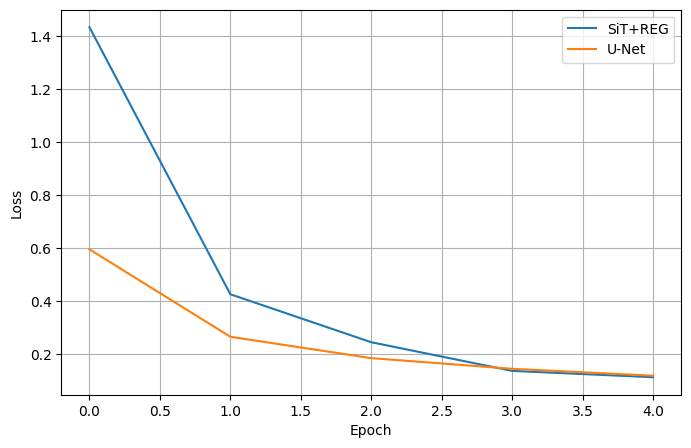

In [7]:
# Improved SiT+REG + U-Net (Colab/T4-ready) with fixed latent_hw and AMP

import os, math, random, shutil
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics

# ---------- CONFIG ----------
class CFG:
    # Data
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 64
    batch_size = 128
    num_workers = 2

    # Latent / patch
    latent_hw = 16           # FIXED: match VAE output
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2

    # SiT
    depth = 12
    hidden_dim = 512
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.1

    # U-Net baseline
    unet_base = 128
    unet_mult = [1,2,2,4]

    # Training
    timesteps = 250
    lr = 1e-4
    weight_decay = 1e-2
    betas = (0.9, 0.999)
    epochs = 5
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_beta = 0.03
    reg_lambda = 0.5
    feat_dim = 256
    align_layer = 6

    # Eval / sampling
    sample_n = 500
    out_dir = "./outputs_improved"
    ema_decay = 0.999
    cfg_guidance_scale = 4.0

cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = cfg.device
print("Device:", device)

# ---------- utilities ----------
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-6, 0.999)

# ---------- Scheduler ----------
class Scheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        betas = cosine_beta_schedule(timesteps).to(device)
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1,0), value=1.0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = betas * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)

    def sample_t(self, n):
        return torch.randint(0, self.timesteps, (n,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a = self.sqrt_alpha_cumprod[t].view(-1,1,1,1)
        b = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
        return a * x0 + b * noise, noise

    def v_target(self, x0, eps):
        return eps

scheduler = Scheduler(cfg.timesteps, device)

# ---------- Data ----------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    idx_map = {n:i for i,n in enumerate(class_names)}
    target_idxs = {idx_map[c] for c in classes}
    tfs = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=tfs)
    indices = [i for i,(_,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)

# ---------- VAE ----------
class VAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        # Encoder 64 -> 16
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, latent_channels, 3, 1, 1)
        )
        self.dec = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)

vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("Pretraining VAE (2 epochs)...")
vae.train()
for ep in range(2):
    pbar = tqdm(dataloader, desc=f"VAE warmup {ep+1}/2")
    for imgs,_ in pbar:
        imgs = imgs.to(device)
        z = vae.encode(imgs)
        recon = vae.decode(z)
        loss = F.mse_loss(recon, imgs)
        vae_opt.zero_grad(); loss.backward(); vae_opt.step()
        pbar.set_postfix({'loss':f"{loss.item():.4f}"})
print("VAE warmup done")

# ---------- timestep embedding ----------
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(half, dtype=torch.float32) / half).to(device)
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

# ---------- Transformer blocks ----------
class MHA(nn.Module):
    def __init__(self, dim, heads): super().__init__(); self.heads=heads; self.to_qkv=nn.Linear(dim,dim*3,bias=False); self.scale=(dim//heads)**-0.5; self.to_out=nn.Linear(dim,dim)
    def forward(self,x):
        B,N,C=x.shape
        qkv=self.to_qkv(x).reshape(B,N,3,self.heads,C//self.heads).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]
        attn=(q@k.transpose(-2,-1))*self.scale
        attn=attn.softmax(dim=-1)
        out=(attn@v).transpose(1,2).reshape(B,N,C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1=nn.LayerNorm(dim)
        self.attn=MHA(dim, cfg.num_heads)
        self.norm2=nn.LayerNorm(dim)
        mlp_dim=int(dim*cfg.mlp_ratio)
        self.mlp=nn.Sequential(nn.Linear(dim,mlp_dim), nn.GELU(), nn.Linear(mlp_dim,dim))
    def forward(self,x):
        x=x+self.attn(self.norm1(x))
        x=x+self.mlp(self.norm2(x))
        return x

# ---------- REGSiT ----------
class REGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim=cfg.hidden_dim
        self.patch_embed=nn.Linear(cfg.latent_patch_dim,self.hidden_dim)
        self.class_embed=nn.Linear(cfg.feat_dim,self.hidden_dim)
        self.pos=nn.Parameter(torch.zeros(1,cfg.num_patches+1,self.hidden_dim))
        self.time_mlp=nn.Sequential(nn.Linear(self.hidden_dim,self.hidden_dim*4), nn.SiLU(), nn.Linear(self.hidden_dim*4,self.hidden_dim))
        self.blocks=nn.ModuleList([TransformerBlock(self.hidden_dim) for _ in range(cfg.depth)])
        self.norm=nn.LayerNorm(self.hidden_dim)
        self.patch_out=nn.Linear(self.hidden_dim,cfg.latent_patch_dim)
        self.cls_out=nn.Linear(self.hidden_dim,cfg.feat_dim)
        self.align_proj=nn.Linear(self.hidden_dim,cfg.feat_dim)
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.zeros_(m.bias); nn.init.ones_(m.weight)
    def forward(self, z_patched, cls_token, t):
        B=z_patched.shape[0]
        patch_emb=self.patch_embed(z_patched)
        cls_emb=self.class_embed(cls_token).unsqueeze(1)
        x=torch.cat([cls_emb,patch_emb],dim=1)+self.pos
        t_emb=timestep_embedding(t,self.hidden_dim).to(x.device)
        t_emb=self.time_mlp(t_emb).unsqueeze(1)
        x=x+t_emb
        intermediate=None
        for i,blk in enumerate(self.blocks):
            x=blk(x)
            if i==cfg.align_layer: intermediate=x
        x=self.norm(x)
        cls_pred=self.cls_out(x[:,0])
        patch_pred=self.patch_out(x[:,1:])
        h_phi=self.align_proj(intermediate) if intermediate is not None else None
        return patch_pred, cls_pred, h_phi

reg_sit=REGSiT().to(device)
print("SiT params:", sum(p.numel() for p in reg_sit.parameters()))

# ---------- rest of code (VisionFoundation, REGModel, UNet, EMA, training, sampling, evaluation) ----------
# Keep your original code, but everywhere `latent_hw` is used, it is now 16
# Update GradScaler / autocast:
# scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
# with torch.amp.autocast(enabled=torch.cuda.is_available()):


# ---------- Vision foundation (small frozen conv, produce class token and patch targets) ----------
class VisionFoundation(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(128, cfg.feat_dim)
        for p in self.parameters(): p.requires_grad = False
    def extract(self, x):
        B = x.shape[0]
        f = self.backbone(x).view(B,-1)
        feat = F.normalize(self.proj(f), dim=-1)
        cls = feat
        patch = feat.unsqueeze(1).repeat(1, cfg.num_patches, 1)
        return cls, patch

vision = VisionFoundation().to(device)

# ---------- REG wrapper computing loss ----------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision
    def forward(self, imgs, t_idx):
        B = imgs.shape[0]
        z_star = self.vae.encode(imgs)
        cls_star, f_star = self.vision.extract(imgs)
        eps_z = torch.randn_like(z_star)
        eps_cls = torch.randn_like(cls_star)
        zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps_z)
        # class noise: use same coef forms as scheduler
        a = scheduler.sqrt_alpha_cumprod[t_idx].view(B,1)
        b = scheduler.sqrt_one_minus_alpha_cumprod[t_idx].view(B,1)
        clst = a * cls_star + b * eps_cls
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_idx)
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        v_target_z = scheduler.v_target(z_star, eps_z)
        v_target_cls = scheduler.v_target(cls_star, eps_cls)
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.reg_beta * F.mse_loss(v_cls, v_target_cls)
        loss_align = torch.tensor(0.0, device=device)
        if h_phi is not None:
            y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)
            loss_align = F.mse_loss(h_phi, y_star.detach())
        total_loss = loss_pred + cfg.reg_lambda * loss_align
        return total_loss, loss_pred.detach().item(), loss_align.detach().item()

reg_model = REGModel(reg_sit, vae, vision).to(device)

# ---------- U-Net baseline (wider) ----------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU())
    def forward(self,x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        base = cfg.unet_base
        self.time_dim = 256
        self.time_mlp = nn.Sequential(nn.Linear(self.time_dim, self.time_dim*4), nn.SiLU(), nn.Linear(self.time_dim*4, self.time_dim))
        chs = [base * m for m in cfg.unet_mult]
        self.enc1 = ConvBlock(cfg.latent_channels, chs[0])
        self.enc2 = ConvBlock(chs[0], chs[1])
        self.enc3 = ConvBlock(chs[1], chs[2])
        self.mid = ConvBlock(chs[2], chs[2])
        self.dec1 = nn.ConvTranspose2d(chs[2], chs[1], 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(chs[1]*2, chs[0], 4, 2, 1)
        self.out = nn.Conv2d(chs[0]*2, cfg.latent_channels, 3, 1, 1)
        self.time_projs = nn.ModuleList([nn.Linear(self.time_dim, c) for c in (chs[0], chs[1], chs[2], chs[2], chs[1], chs[0])])
    def forward(self, x, t):
        B = x.shape[0]
        t_emb = timestep_embedding(t, self.time_dim).to(x.device)
        t_emb = self.time_mlp(t_emb)
        x1 = F.silu(self.enc1(x) + self.time_projs[0](t_emb).view(B, -1, 1, 1))
        x2 = F.silu(self.enc2(F.avg_pool2d(x1,2)) + self.time_projs[1](t_emb).view(B, -1, 1, 1))
        x3 = F.silu(self.enc3(F.avg_pool2d(x2,2)) + self.time_projs[2](t_emb).view(B, -1, 1, 1))
        m = F.silu(self.mid(x3) + self.time_projs[3](t_emb).view(B, -1, 1, 1))
        d1 = F.silu(self.dec1(m) + self.time_projs[4](t_emb).view(B, -1, 1, 1))
        d1 = torch.cat([d1, x2], dim=1)
        d2 = F.silu(self.dec2(d1) + self.time_projs[5](t_emb).view(B, -1, 1, 1))
        d2 = torch.cat([d2, x1], dim=1)
        out = self.out(d2)
        return out

unet = UNetSmall().to(device)

# ---------- Optimizers, EMA, AMP ----------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:  # only float tensors
                self.shadow[k] = v.detach().cpu().clone()

    def update(self, model):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay)
                self.shadow[k].add_(v.detach().cpu(), alpha=1.0 - self.decay)

    def apply_to(self, model):
        ms = model.state_dict()
        for k, v in self.shadow.items():
            ms[k].copy_(v.to(ms[k].device))

ema_reg = EMA(reg_model, cfg.ema_decay)
ema_unet = EMA(unet, cfg.ema_decay)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ---------- Training loops ----------
reg_loss_hist, unet_loss_hist = [], []

def train_reg(epochs):
    reg_model.train()
    for ep in range(epochs):
        total, tot_pred, tot_align = 0.0, 0.0, 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {ep+1}/{epochs}")
        for imgs,_ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            t_idx = scheduler.sample_t(B)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                loss, lp, la = reg_model(imgs, t_idx)
            opt_reg.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_reg)
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            scaler.step(opt_reg); scaler.update()
            ema_reg.update(reg_model)
            total += loss.item(); tot_pred += lp; tot_align += la
            pbar.set_postfix({'loss':f"{loss.item():.4f}", 'pred':f"{lp:.4f}", 'align':f"{la:.4f}"})
        avg = total / len(dataloader)
        reg_loss_hist.append(avg)
        print(f"REG Epoch {ep+1} avg {avg:.4f}")

def train_unet(epochs):
    unet.train()
    for ep in range(epochs):
        total = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {ep+1}/{epochs}")
        for imgs,_ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            with torch.no_grad(): z_star = vae.encode(imgs)
            t_idx = scheduler.sample_t(B)
            eps = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                v_pred = unet(zt, t_idx)
                loss = F.mse_loss(v_pred, eps)
            opt_unet.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_unet)
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            scaler.step(opt_unet); scaler.update()
            ema_unet.update(unet)
            total += loss.item()
            pbar.set_postfix({'loss':f"{loss.item():.4f}"})
        avg = total / len(dataloader)
        unet_loss_hist.append(avg)
        print(f"UNet Epoch {ep+1} avg {avg:.4f}")

# ---------- EM sampler (v-pred) ----------
@torch.no_grad()
def em_update(z, v_pred, t_idx, t_prev_idx):
    # z: (B,C,H,W), v_pred: same
    alpha = scheduler.alpha_cumprod[t_idx].view(-1,1,1,1)
    alpha_prev = scheduler.alpha_cumprod[t_prev_idx].view(-1,1,1,1)
    sigma = scheduler.sqrt_one_minus_alpha_cumprod[t_idx].view(-1,1,1,1)
    sigma_prev = scheduler.sqrt_one_minus_alpha_cumprod[t_prev_idx].view(-1,1,1,1)
    # x0_hat estimate for v-pred: x0 = (z - sigma * v) / alpha
    x0_hat = (z - sigma * v_pred) / (alpha + 1e-12)
    if (t_prev_idx==t_idx).all():
        return alpha_prev * x0_hat
    noise = torch.randn_like(z)
    z_prev = alpha_prev * x0_hat + sigma_prev * noise
    return z_prev

@torch.no_grad()
def sample_unet(n, batch_size=64):
    all_imgs = []
    for i in range(0, n, batch_size):
        b = min(batch_size, n - i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        for t in tqdm(range(cfg.timesteps-1, -1, -1), desc="UNet Sampling", leave=False):
            t_idx = torch.full((b,), t, device=device, dtype=torch.long)
            v = unet(z, t_idx)
            t_prev = torch.clamp(t_idx - 1, min=0)
            z = em_update(z, v, t_idx, t_prev)
        imgs = vae.decode(z)
        all_imgs.append(torch.clamp((imgs + 1)/2, 0, 1).cpu())
    return torch.cat(all_imgs, dim=0)

@torch.no_grad()
def sample_reg(n, cfg_guidance=cfg.cfg_guidance_scale, batch_size=64):
    all_imgs = []
    for i in range(0, n, batch_size):
        b = min(batch_size, n - i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        cls = torch.randn(b, cfg.feat_dim, device=device)
        for t in tqdm(range(cfg.timesteps-1, -1, -1), desc="REG Sampling", leave=False):
            t_idx = torch.full((b,), t, device=device, dtype=torch.long)
            z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                                  p=cfg.patch_size, q=cfg.patch_size,
                                  h=cfg.latent_hw//cfg.patch_size,
                                  w=cfg.latent_hw//cfg.patch_size)
            v_patch, v_cls, _ = reg_sit(z_patched, cls, t_idx)
            v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                            p=cfg.patch_size, q=cfg.patch_size,
                            h=cfg.latent_hw//cfg.patch_size,
                            w=cfg.latent_hw//cfg.patch_size,
                            c=cfg.latent_channels)
            # classifier-free guidance: scale v_cls
            v_cls = v_cls * cfg_guidance
            t_prev = torch.clamp(t_idx - 1, min=0)
            z = em_update(z, v_z, t_idx, t_prev)
            # update class token
            cls = cls - 0.01 * v_cls
        imgs = vae.decode(z)
        all_imgs.append(torch.clamp((imgs + 1)/2, 0, 1).cpu())
    return torch.cat(all_imgs, dim=0)

# ---------- Evaluation ----------
def save_grid(imgs, path, nrow=10):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)

@torch.no_grad()
def evaluate(num_samples=cfg.sample_n):
    results = {}
    real_dir = os.path.join(cfg.out_dir, f"real_{num_samples}")
    if os.path.exists(real_dir): shutil.rmtree(real_dir)
    os.makedirs(real_dir, exist_ok=True)
    cnt = 0
    for imgs,_ in dataloader:
        for im in imgs:
            torchvision.utils.save_image((im+1)/2, os.path.join(real_dir, f"{cnt:05d}.png"))
            cnt += 1
            if cnt >= num_samples: break
        if cnt >= num_samples: break

    for typ in ['reg','unet']:
        print("Generating", typ)
        if typ == 'reg':
            ema_reg.apply_to(reg_model)
            gen = sample_reg(num_samples, cfg_guidance=cfg.cfg_guidance_scale, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, "reg_samples.png"), nrow=10)
        else:
            ema_unet.apply_to(unet)
            gen = sample_unet(num_samples, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, "unet_samples.png"), nrow=10)
        gen_dir = os.path.join(cfg.out_dir, f"{typ}_gen")
        if os.path.exists(gen_dir): shutil.rmtree(gen_dir)
        os.makedirs(gen_dir, exist_ok=True)
        for i,im in enumerate(gen):
            torchvision.utils.save_image(im, os.path.join(gen_dir, f"{i:05d}.png"))
        print("Calculating metrics (may take a while)...")
        try:
            metrics = calculate_metrics(input1=gen_dir, input2=real_dir, cuda=torch.cuda.is_available(), isc=True, fid=True, kid=False, verbose=False)
            results[typ] = metrics
            print(f"{typ} FID={metrics['frechet_inception_distance']:.2f}, IS={metrics['inception_score_mean']:.2f}")
        except Exception as e:
            print("Metric error:", e)
            results[typ] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}
    return results

# ---------- Plot losses ----------
def plot_losses():
    plt.figure(figsize=(8,5))
    if reg_loss_hist: plt.plot(reg_loss_hist, label='SiT+REG')
    if unet_loss_hist: plt.plot(unet_loss_hist, label='U-Net')
    plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
    plt.savefig(os.path.join(cfg.out_dir, "losses.png"), dpi=200)

# ---------- MAIN ----------
if __name__ == "__main__":
    print("="*60)
    print("START TRAINING: SiT+REG and U-Net (improved config)")
    print("="*60)
    # Train
    train_reg(cfg.epochs)
    train_unet(cfg.epochs)
    plot_losses()
    print("Applying EMA and evaluating with CFG...")
    ema_reg.apply_to(reg_model)
    ema_unet.apply_to(unet)
    results = evaluate(cfg.sample_n)
    print("FINAL RESULTS:")
    for k,v in results.items():
        fid = v.get('frechet_inception_distance', float('inf'))
        is_ = v.get('inception_score_mean', 0.0)
        print(f"{k.upper():<6} | FID: {fid:8.2f} | IS: {is_:6.2f}")
    print("Done. Outputs in", cfg.out_dir)

# ---------- END ----------


Device: cuda
Loaded 10000 images (['cat', 'dog'])
Pretraining VAE (2 epochs)...


VAE warmup 2/2: 100%|██████████| 78/78 [00:19<00:00,  4.03it/s, loss=0.0073]


VAE warmup done


/tmp/ipython-input-1031646778.py:380: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


SiT params: 40355344
START TRAINING: SiT+REG and U-Net (improved config)


REG Epoch 1/100:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-1031646778.py:394: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
REG Epoch 1/100: 100%|██████████| 78/78 [00:26<00:00,  3.00it/s, loss=0.5023, pred=0.4297, align=0.1452]


REG Epoch 1 avg 1.4225


REG Epoch 2/100: 100%|██████████| 78/78 [00:27<00:00,  2.89it/s, loss=0.3965, pred=0.3229, align=0.1472]


REG Epoch 2 avg 0.4177


REG Epoch 3/100: 100%|██████████| 78/78 [00:27<00:00,  2.88it/s, loss=0.2222, pred=0.1472, align=0.1499]


REG Epoch 3 avg 0.2982


REG Epoch 4/100: 100%|██████████| 78/78 [00:26<00:00,  2.97it/s, loss=0.1475, pred=0.1126, align=0.0699]


REG Epoch 4 avg 0.1405


REG Epoch 5/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0944, pred=0.0621, align=0.0645]


REG Epoch 5 avg 0.1041


REG Epoch 6/100: 100%|██████████| 78/78 [00:26<00:00,  2.95it/s, loss=0.0753, pred=0.0547, align=0.0413]


REG Epoch 6 avg 0.0842


REG Epoch 7/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0907, pred=0.0670, align=0.0475]


REG Epoch 7 avg 0.0790


REG Epoch 8/100: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s, loss=0.0859, pred=0.0576, align=0.0565]


REG Epoch 8 avg 0.0800


REG Epoch 9/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0649, pred=0.0461, align=0.0376]


REG Epoch 9 avg 0.0752


REG Epoch 10/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0708, pred=0.0560, align=0.0297]


REG Epoch 10 avg 0.0681


REG Epoch 11/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0623, pred=0.0519, align=0.0207]


REG Epoch 11 avg 0.0686


REG Epoch 12/100: 100%|██████████| 78/78 [00:26<00:00,  2.95it/s, loss=0.0657, pred=0.0510, align=0.0294]


REG Epoch 12 avg 0.0644


REG Epoch 13/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0553, pred=0.0380, align=0.0347]


REG Epoch 13 avg 0.0638


REG Epoch 14/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0512, pred=0.0395, align=0.0232]


REG Epoch 14 avg 0.0679


REG Epoch 15/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0475, pred=0.0385, align=0.0181]


REG Epoch 15 avg 0.0587


REG Epoch 16/100: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s, loss=0.0626, pred=0.0467, align=0.0317]


REG Epoch 16 avg 0.0656


REG Epoch 17/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0641, pred=0.0559, align=0.0164]


REG Epoch 17 avg 0.0579


REG Epoch 18/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0478, pred=0.0392, align=0.0172]


REG Epoch 18 avg 0.0541


REG Epoch 19/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0455, pred=0.0373, align=0.0165]


REG Epoch 19 avg 0.0497


REG Epoch 20/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0735, pred=0.0598, align=0.0273]


REG Epoch 20 avg 0.0554


REG Epoch 21/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0730, pred=0.0455, align=0.0549]


REG Epoch 21 avg 0.0564


REG Epoch 22/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0444, pred=0.0341, align=0.0207]


REG Epoch 22 avg 0.0488


REG Epoch 23/100: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s, loss=0.0479, pred=0.0389, align=0.0180]


REG Epoch 23 avg 0.0506


REG Epoch 24/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0373, pred=0.0302, align=0.0143]


REG Epoch 24 avg 0.0494


REG Epoch 25/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0386, pred=0.0301, align=0.0169]


REG Epoch 25 avg 0.0464


REG Epoch 26/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0378, pred=0.0295, align=0.0166]


REG Epoch 26 avg 0.0443


REG Epoch 27/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0426, pred=0.0337, align=0.0179]


REG Epoch 27 avg 0.0467


REG Epoch 28/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0566, pred=0.0367, align=0.0398]


REG Epoch 28 avg 0.0528


REG Epoch 29/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0382, pred=0.0298, align=0.0168]


REG Epoch 29 avg 0.0452


REG Epoch 30/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0367, pred=0.0298, align=0.0137]


REG Epoch 30 avg 0.0425


REG Epoch 31/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0871, pred=0.0534, align=0.0674]


REG Epoch 31 avg 0.0446


REG Epoch 32/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0383, pred=0.0239, align=0.0288]


REG Epoch 32 avg 0.0384


REG Epoch 33/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0576, pred=0.0342, align=0.0468]


REG Epoch 33 avg 0.0431


REG Epoch 34/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0389, pred=0.0328, align=0.0121]


REG Epoch 34 avg 0.0381


REG Epoch 35/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0444, pred=0.0281, align=0.0328]


REG Epoch 35 avg 0.0381


REG Epoch 36/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0230, pred=0.0179, align=0.0101]


REG Epoch 36 avg 0.0361


REG Epoch 37/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0220, pred=0.0182, align=0.0076]


REG Epoch 37 avg 0.0316


REG Epoch 38/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0380, pred=0.0302, align=0.0155]


REG Epoch 38 avg 0.0320


REG Epoch 39/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0219, pred=0.0166, align=0.0106]


REG Epoch 39 avg 0.0318


REG Epoch 40/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0184, pred=0.0147, align=0.0073]


REG Epoch 40 avg 0.0255


REG Epoch 41/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0288, pred=0.0241, align=0.0094]


REG Epoch 41 avg 0.0289


REG Epoch 42/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0368, pred=0.0253, align=0.0231]


REG Epoch 42 avg 0.0285


REG Epoch 43/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0215, pred=0.0170, align=0.0090]


REG Epoch 43 avg 0.0251


REG Epoch 44/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0227, pred=0.0163, align=0.0129]


REG Epoch 44 avg 0.0231


REG Epoch 45/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0206, pred=0.0160, align=0.0091]


REG Epoch 45 avg 0.0255


REG Epoch 46/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0497, pred=0.0304, align=0.0387]


REG Epoch 46 avg 0.0257


REG Epoch 47/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0245, pred=0.0139, align=0.0212]


REG Epoch 47 avg 0.0277


REG Epoch 48/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0254, pred=0.0197, align=0.0115]


REG Epoch 48 avg 0.0208


REG Epoch 49/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0142, pred=0.0115, align=0.0054]


REG Epoch 49 avg 0.0195


REG Epoch 50/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0139, pred=0.0107, align=0.0065]


REG Epoch 50 avg 0.0181


REG Epoch 51/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0240, pred=0.0143, align=0.0194]


REG Epoch 51 avg 0.0183


REG Epoch 52/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0176, pred=0.0132, align=0.0090]


REG Epoch 52 avg 0.0212


REG Epoch 53/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0342, pred=0.0287, align=0.0109]


REG Epoch 53 avg 0.0207


REG Epoch 54/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0190, pred=0.0152, align=0.0076]


REG Epoch 54 avg 0.0214


REG Epoch 55/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0109, pred=0.0081, align=0.0056]


REG Epoch 55 avg 0.0178


REG Epoch 56/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0197, pred=0.0143, align=0.0107]


REG Epoch 56 avg 0.0175


REG Epoch 57/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0182, pred=0.0106, align=0.0151]


REG Epoch 57 avg 0.0215


REG Epoch 58/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0174, pred=0.0100, align=0.0147]


REG Epoch 58 avg 0.0179


REG Epoch 59/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0174, pred=0.0132, align=0.0084]


REG Epoch 59 avg 0.0193


REG Epoch 60/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0142, pred=0.0099, align=0.0085]


REG Epoch 60 avg 0.0183


REG Epoch 61/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0109, pred=0.0079, align=0.0061]


REG Epoch 61 avg 0.0167


REG Epoch 62/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0119, pred=0.0086, align=0.0067]


REG Epoch 62 avg 0.0162


REG Epoch 63/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0172, pred=0.0139, align=0.0065]


REG Epoch 63 avg 0.0153


REG Epoch 64/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0132, pred=0.0082, align=0.0099]


REG Epoch 64 avg 0.0183


REG Epoch 65/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0130, pred=0.0108, align=0.0045]


REG Epoch 65 avg 0.0131


REG Epoch 66/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0084, pred=0.0054, align=0.0061]


REG Epoch 66 avg 0.0117


REG Epoch 67/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0135, pred=0.0070, align=0.0131]


REG Epoch 67 avg 0.0139


REG Epoch 68/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0113, pred=0.0096, align=0.0035]


REG Epoch 68 avg 0.0122


REG Epoch 69/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0102, pred=0.0077, align=0.0049]


REG Epoch 69 avg 0.0125


REG Epoch 70/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0152, pred=0.0116, align=0.0072]


REG Epoch 70 avg 0.0132


REG Epoch 71/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0163, pred=0.0120, align=0.0086]


REG Epoch 71 avg 0.0155


REG Epoch 72/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0110, pred=0.0086, align=0.0048]


REG Epoch 72 avg 0.0159


REG Epoch 73/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0119, pred=0.0094, align=0.0050]


REG Epoch 73 avg 0.0129


REG Epoch 74/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0218, pred=0.0134, align=0.0167]


REG Epoch 74 avg 0.0156


REG Epoch 75/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0098, pred=0.0066, align=0.0063]


REG Epoch 75 avg 0.0134


REG Epoch 76/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0284, pred=0.0221, align=0.0126]


REG Epoch 76 avg 0.0156


REG Epoch 77/100: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s, loss=0.0189, pred=0.0096, align=0.0185]


REG Epoch 77 avg 0.0202


REG Epoch 78/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0109, pred=0.0089, align=0.0041]


REG Epoch 78 avg 0.0131


REG Epoch 79/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0096, pred=0.0078, align=0.0037]


REG Epoch 79 avg 0.0100


REG Epoch 80/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0092, pred=0.0072, align=0.0041]


REG Epoch 80 avg 0.0102


REG Epoch 81/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0187, pred=0.0142, align=0.0091]


REG Epoch 81 avg 0.0136


REG Epoch 82/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0212, pred=0.0188, align=0.0049]


REG Epoch 82 avg 0.0114


REG Epoch 83/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0104, pred=0.0085, align=0.0037]


REG Epoch 83 avg 0.0124


REG Epoch 84/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0179, pred=0.0125, align=0.0107]


REG Epoch 84 avg 0.0122


REG Epoch 85/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0140, pred=0.0124, align=0.0032]


REG Epoch 85 avg 0.0097


REG Epoch 86/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0118, pred=0.0093, align=0.0052]


REG Epoch 86 avg 0.0116


REG Epoch 87/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0111, pred=0.0079, align=0.0064]


REG Epoch 87 avg 0.0110


REG Epoch 88/100: 100%|██████████| 78/78 [00:26<00:00,  2.94it/s, loss=0.0094, pred=0.0076, align=0.0037]


REG Epoch 88 avg 0.0091


REG Epoch 89/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0163, pred=0.0131, align=0.0066]


REG Epoch 89 avg 0.0110


REG Epoch 90/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0137, pred=0.0099, align=0.0076]


REG Epoch 90 avg 0.0125


REG Epoch 91/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0075, pred=0.0055, align=0.0040]


REG Epoch 91 avg 0.0105


REG Epoch 92/100: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s, loss=0.0112, pred=0.0075, align=0.0075]


REG Epoch 92 avg 0.0092


REG Epoch 93/100: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s, loss=0.0131, pred=0.0105, align=0.0052]


REG Epoch 93 avg 0.0091


REG Epoch 94/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0061, pred=0.0043, align=0.0035]


REG Epoch 94 avg 0.0101


REG Epoch 95/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0069, pred=0.0055, align=0.0029]


REG Epoch 95 avg 0.0069


REG Epoch 96/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0091, pred=0.0071, align=0.0039]


REG Epoch 96 avg 0.0101


REG Epoch 97/100: 100%|██████████| 78/78 [00:26<00:00,  2.91it/s, loss=0.0129, pred=0.0097, align=0.0063]


REG Epoch 97 avg 0.0147


REG Epoch 98/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0100, pred=0.0078, align=0.0044]


REG Epoch 98 avg 0.0118


REG Epoch 99/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0064, pred=0.0046, align=0.0035]


REG Epoch 99 avg 0.0146


REG Epoch 100/100: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.0063, pred=0.0049, align=0.0028]


REG Epoch 100 avg 0.0097


UNet Epoch 1/100:   0%|          | 0/78 [00:00<?, ?it/s]/tmp/ipython-input-1031646778.py:420: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
UNet Epoch 1/100: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s, loss=0.2352]


UNet Epoch 1 avg 0.5069


UNet Epoch 2/100: 100%|██████████| 78/78 [00:06<00:00, 12.75it/s, loss=0.1495]


UNet Epoch 2 avg 0.1744


UNet Epoch 3/100: 100%|██████████| 78/78 [00:07<00:00, 10.94it/s, loss=0.0964]


UNet Epoch 3 avg 0.1153


UNet Epoch 4/100: 100%|██████████| 78/78 [00:06<00:00, 12.56it/s, loss=0.0685]


UNet Epoch 4 avg 0.0868


UNet Epoch 5/100: 100%|██████████| 78/78 [00:07<00:00, 10.83it/s, loss=0.0653]


UNet Epoch 5 avg 0.0772


UNet Epoch 6/100: 100%|██████████| 78/78 [00:06<00:00, 12.72it/s, loss=0.0604]


UNet Epoch 6 avg 0.0656


UNet Epoch 7/100: 100%|██████████| 78/78 [00:07<00:00, 10.91it/s, loss=0.0570]


UNet Epoch 7 avg 0.0594


UNet Epoch 8/100: 100%|██████████| 78/78 [00:06<00:00, 12.62it/s, loss=0.0508]


UNet Epoch 8 avg 0.0538


UNet Epoch 9/100: 100%|██████████| 78/78 [00:07<00:00, 10.87it/s, loss=0.0465]


UNet Epoch 9 avg 0.0483


UNet Epoch 10/100: 100%|██████████| 78/78 [00:06<00:00, 12.53it/s, loss=0.0447]


UNet Epoch 10 avg 0.0430


UNet Epoch 11/100: 100%|██████████| 78/78 [00:07<00:00, 10.94it/s, loss=0.0505]


UNet Epoch 11 avg 0.0382


UNet Epoch 12/100: 100%|██████████| 78/78 [00:06<00:00, 12.57it/s, loss=0.0362]


UNet Epoch 12 avg 0.0351


UNet Epoch 13/100: 100%|██████████| 78/78 [00:07<00:00, 11.09it/s, loss=0.0317]


UNet Epoch 13 avg 0.0313


UNet Epoch 14/100: 100%|██████████| 78/78 [00:06<00:00, 12.03it/s, loss=0.0248]


UNet Epoch 14 avg 0.0274


UNet Epoch 15/100: 100%|██████████| 78/78 [00:06<00:00, 11.52it/s, loss=0.0265]


UNet Epoch 15 avg 0.0255


UNet Epoch 16/100: 100%|██████████| 78/78 [00:06<00:00, 11.74it/s, loss=0.0203]


UNet Epoch 16 avg 0.0227


UNet Epoch 17/100: 100%|██████████| 78/78 [00:06<00:00, 11.89it/s, loss=0.0233]


UNet Epoch 17 avg 0.0223


UNet Epoch 18/100: 100%|██████████| 78/78 [00:06<00:00, 11.37it/s, loss=0.0201]


UNet Epoch 18 avg 0.0206


UNet Epoch 19/100: 100%|██████████| 78/78 [00:06<00:00, 12.30it/s, loss=0.0184]


UNet Epoch 19 avg 0.0185


UNet Epoch 20/100: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s, loss=0.0158]


UNet Epoch 20 avg 0.0174


UNet Epoch 21/100: 100%|██████████| 78/78 [00:06<00:00, 12.73it/s, loss=0.0169]


UNet Epoch 21 avg 0.0173


UNet Epoch 22/100: 100%|██████████| 78/78 [00:07<00:00, 10.97it/s, loss=0.0147]


UNet Epoch 22 avg 0.0159


UNet Epoch 23/100: 100%|██████████| 78/78 [00:06<00:00, 12.54it/s, loss=0.0131]


UNet Epoch 23 avg 0.0148


UNet Epoch 24/100: 100%|██████████| 78/78 [00:07<00:00, 10.99it/s, loss=0.0120]


UNet Epoch 24 avg 0.0139


UNet Epoch 25/100: 100%|██████████| 78/78 [00:06<00:00, 12.70it/s, loss=0.0122]


UNet Epoch 25 avg 0.0127


UNet Epoch 26/100: 100%|██████████| 78/78 [00:06<00:00, 11.20it/s, loss=0.0115]


UNet Epoch 26 avg 0.0128


UNet Epoch 27/100: 100%|██████████| 78/78 [00:06<00:00, 12.67it/s, loss=0.0105]


UNet Epoch 27 avg 0.0120


UNet Epoch 28/100: 100%|██████████| 78/78 [00:07<00:00, 10.98it/s, loss=0.0099]


UNet Epoch 28 avg 0.0109


UNet Epoch 29/100: 100%|██████████| 78/78 [00:06<00:00, 12.66it/s, loss=0.0100]


UNet Epoch 29 avg 0.0108


UNet Epoch 30/100: 100%|██████████| 78/78 [00:06<00:00, 11.16it/s, loss=0.0094]


UNet Epoch 30 avg 0.0104


UNet Epoch 31/100: 100%|██████████| 78/78 [00:06<00:00, 12.71it/s, loss=0.0087]


UNet Epoch 31 avg 0.0102


UNet Epoch 32/100: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s, loss=0.0084]


UNet Epoch 32 avg 0.0099


UNet Epoch 33/100: 100%|██████████| 78/78 [00:06<00:00, 12.79it/s, loss=0.0085]


UNet Epoch 33 avg 0.0091


UNet Epoch 34/100: 100%|██████████| 78/78 [00:07<00:00, 11.06it/s, loss=0.0078]


UNet Epoch 34 avg 0.0088


UNet Epoch 35/100: 100%|██████████| 78/78 [00:06<00:00, 12.95it/s, loss=0.0076]


UNet Epoch 35 avg 0.0081


UNet Epoch 36/100: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s, loss=0.0092]


UNet Epoch 36 avg 0.0080


UNet Epoch 37/100: 100%|██████████| 78/78 [00:06<00:00, 12.62it/s, loss=0.0066]


UNet Epoch 37 avg 0.0075


UNet Epoch 38/100: 100%|██████████| 78/78 [00:07<00:00, 11.09it/s, loss=0.0074]


UNet Epoch 38 avg 0.0073


UNet Epoch 39/100: 100%|██████████| 78/78 [00:06<00:00, 12.58it/s, loss=0.0068]


UNet Epoch 39 avg 0.0071


UNet Epoch 40/100: 100%|██████████| 78/78 [00:06<00:00, 11.30it/s, loss=0.0061]


UNet Epoch 40 avg 0.0074


UNet Epoch 41/100: 100%|██████████| 78/78 [00:06<00:00, 12.25it/s, loss=0.0061]


UNet Epoch 41 avg 0.0065


UNet Epoch 42/100: 100%|██████████| 78/78 [00:06<00:00, 11.61it/s, loss=0.0052]


UNet Epoch 42 avg 0.0065


UNet Epoch 43/100: 100%|██████████| 78/78 [00:06<00:00, 11.67it/s, loss=0.0052]


UNet Epoch 43 avg 0.0062


UNet Epoch 44/100: 100%|██████████| 78/78 [00:06<00:00, 12.23it/s, loss=0.0075]


UNet Epoch 44 avg 0.0060


UNet Epoch 45/100: 100%|██████████| 78/78 [00:06<00:00, 11.39it/s, loss=0.0094]


UNet Epoch 45 avg 0.0059


UNet Epoch 46/100: 100%|██████████| 78/78 [00:06<00:00, 12.38it/s, loss=0.0059]


UNet Epoch 46 avg 0.0057


UNet Epoch 47/100: 100%|██████████| 78/78 [00:07<00:00, 11.01it/s, loss=0.0059]


UNet Epoch 47 avg 0.0054


UNet Epoch 48/100: 100%|██████████| 78/78 [00:06<00:00, 12.73it/s, loss=0.0043]


UNet Epoch 48 avg 0.0054


UNet Epoch 49/100: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s, loss=0.0046]


UNet Epoch 49 avg 0.0054


UNet Epoch 50/100: 100%|██████████| 78/78 [00:06<00:00, 12.70it/s, loss=0.0052]


UNet Epoch 50 avg 0.0051


UNet Epoch 51/100: 100%|██████████| 78/78 [00:07<00:00, 10.93it/s, loss=0.0044]


UNet Epoch 51 avg 0.0049


UNet Epoch 52/100: 100%|██████████| 78/78 [00:06<00:00, 12.70it/s, loss=0.0036]


UNet Epoch 52 avg 0.0047


UNet Epoch 53/100: 100%|██████████| 78/78 [00:07<00:00, 11.11it/s, loss=0.0051]


UNet Epoch 53 avg 0.0046


UNet Epoch 54/100: 100%|██████████| 78/78 [00:06<00:00, 12.78it/s, loss=0.0059]


UNet Epoch 54 avg 0.0045


UNet Epoch 55/100: 100%|██████████| 78/78 [00:07<00:00, 10.89it/s, loss=0.0056]


UNet Epoch 55 avg 0.0046


UNet Epoch 56/100: 100%|██████████| 78/78 [00:06<00:00, 12.67it/s, loss=0.0056]


UNet Epoch 56 avg 0.0044


UNet Epoch 57/100: 100%|██████████| 78/78 [00:06<00:00, 11.17it/s, loss=0.0042]


UNet Epoch 57 avg 0.0042


UNet Epoch 58/100: 100%|██████████| 78/78 [00:06<00:00, 12.82it/s, loss=0.0049]


UNet Epoch 58 avg 0.0042


UNet Epoch 59/100: 100%|██████████| 78/78 [00:07<00:00, 11.09it/s, loss=0.0047]


UNet Epoch 59 avg 0.0042


UNet Epoch 60/100: 100%|██████████| 78/78 [00:06<00:00, 12.48it/s, loss=0.0035]


UNet Epoch 60 avg 0.0041


UNet Epoch 61/100: 100%|██████████| 78/78 [00:07<00:00, 10.93it/s, loss=0.0032]


UNet Epoch 61 avg 0.0038


UNet Epoch 62/100: 100%|██████████| 78/78 [00:06<00:00, 12.78it/s, loss=0.0040]


UNet Epoch 62 avg 0.0039


UNet Epoch 63/100: 100%|██████████| 78/78 [00:07<00:00, 11.09it/s, loss=0.0038]


UNet Epoch 63 avg 0.0038


UNet Epoch 64/100: 100%|██████████| 78/78 [00:06<00:00, 12.51it/s, loss=0.0034]


UNet Epoch 64 avg 0.0039


UNet Epoch 65/100: 100%|██████████| 78/78 [00:07<00:00, 10.95it/s, loss=0.0041]


UNet Epoch 65 avg 0.0036


UNet Epoch 66/100: 100%|██████████| 78/78 [00:06<00:00, 12.66it/s, loss=0.0041]


UNet Epoch 66 avg 0.0035


UNet Epoch 67/100: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s, loss=0.0034]


UNet Epoch 67 avg 0.0034


UNet Epoch 68/100: 100%|██████████| 78/78 [00:06<00:00, 12.25it/s, loss=0.0036]


UNet Epoch 68 avg 0.0035


UNet Epoch 69/100: 100%|██████████| 78/78 [00:06<00:00, 11.28it/s, loss=0.0041]


UNet Epoch 69 avg 0.0036


UNet Epoch 70/100: 100%|██████████| 78/78 [00:06<00:00, 11.75it/s, loss=0.0032]


UNet Epoch 70 avg 0.0035


UNet Epoch 71/100: 100%|██████████| 78/78 [00:06<00:00, 12.03it/s, loss=0.0029]


UNet Epoch 71 avg 0.0033


UNet Epoch 72/100: 100%|██████████| 78/78 [00:06<00:00, 11.40it/s, loss=0.0027]


UNet Epoch 72 avg 0.0032


UNet Epoch 73/100: 100%|██████████| 78/78 [00:06<00:00, 12.23it/s, loss=0.0025]


UNet Epoch 73 avg 0.0032


UNet Epoch 74/100: 100%|██████████| 78/78 [00:07<00:00, 10.89it/s, loss=0.0028]


UNet Epoch 74 avg 0.0032


UNet Epoch 75/100: 100%|██████████| 78/78 [00:06<00:00, 12.65it/s, loss=0.0029]


UNet Epoch 75 avg 0.0032


UNet Epoch 76/100: 100%|██████████| 78/78 [00:07<00:00, 11.12it/s, loss=0.0033]


UNet Epoch 76 avg 0.0032


UNet Epoch 77/100: 100%|██████████| 78/78 [00:06<00:00, 12.72it/s, loss=0.0038]


UNet Epoch 77 avg 0.0030


UNet Epoch 78/100: 100%|██████████| 78/78 [00:07<00:00, 10.91it/s, loss=0.0027]


UNet Epoch 78 avg 0.0030


UNet Epoch 79/100: 100%|██████████| 78/78 [00:06<00:00, 12.62it/s, loss=0.0024]


UNet Epoch 79 avg 0.0029


UNet Epoch 80/100: 100%|██████████| 78/78 [00:07<00:00, 11.13it/s, loss=0.0037]


UNet Epoch 80 avg 0.0031


UNet Epoch 81/100: 100%|██████████| 78/78 [00:06<00:00, 12.71it/s, loss=0.0043]


UNet Epoch 81 avg 0.0028


UNet Epoch 82/100: 100%|██████████| 78/78 [00:07<00:00, 11.04it/s, loss=0.0023]


UNet Epoch 82 avg 0.0029


UNet Epoch 83/100: 100%|██████████| 78/78 [00:06<00:00, 12.48it/s, loss=0.0023]


UNet Epoch 83 avg 0.0029


UNet Epoch 84/100: 100%|██████████| 78/78 [00:07<00:00, 11.06it/s, loss=0.0024]


UNet Epoch 84 avg 0.0027


UNet Epoch 85/100: 100%|██████████| 78/78 [00:06<00:00, 12.72it/s, loss=0.0022]


UNet Epoch 85 avg 0.0028


UNet Epoch 86/100: 100%|██████████| 78/78 [00:07<00:00, 11.10it/s, loss=0.0039]


UNet Epoch 86 avg 0.0027


UNet Epoch 87/100: 100%|██████████| 78/78 [00:06<00:00, 12.49it/s, loss=0.0023]


UNet Epoch 87 avg 0.0027


UNet Epoch 88/100: 100%|██████████| 78/78 [00:07<00:00, 10.92it/s, loss=0.0030]


UNet Epoch 88 avg 0.0028


UNet Epoch 89/100: 100%|██████████| 78/78 [00:06<00:00, 12.65it/s, loss=0.0028]


UNet Epoch 89 avg 0.0027


UNet Epoch 90/100: 100%|██████████| 78/78 [00:07<00:00, 10.93it/s, loss=0.0024]


UNet Epoch 90 avg 0.0028


UNet Epoch 91/100: 100%|██████████| 78/78 [00:06<00:00, 12.52it/s, loss=0.0022]


UNet Epoch 91 avg 0.0025


UNet Epoch 92/100: 100%|██████████| 78/78 [00:07<00:00, 11.03it/s, loss=0.0020]


UNet Epoch 92 avg 0.0025


UNet Epoch 93/100: 100%|██████████| 78/78 [00:06<00:00, 11.91it/s, loss=0.0031]


UNet Epoch 93 avg 0.0025


UNet Epoch 94/100: 100%|██████████| 78/78 [00:06<00:00, 11.81it/s, loss=0.0028]


UNet Epoch 94 avg 0.0026


UNet Epoch 95/100: 100%|██████████| 78/78 [00:06<00:00, 11.54it/s, loss=0.0031]


UNet Epoch 95 avg 0.0026


UNet Epoch 96/100: 100%|██████████| 78/78 [00:06<00:00, 12.02it/s, loss=0.0024]


UNet Epoch 96 avg 0.0026


UNet Epoch 97/100: 100%|██████████| 78/78 [00:07<00:00, 11.05it/s, loss=0.0020]


UNet Epoch 97 avg 0.0024


UNet Epoch 98/100: 100%|██████████| 78/78 [00:06<00:00, 12.70it/s, loss=0.0021]


UNet Epoch 98 avg 0.0025


UNet Epoch 99/100: 100%|██████████| 78/78 [00:07<00:00, 11.08it/s, loss=0.0023]


UNet Epoch 99 avg 0.0025


UNet Epoch 100/100: 100%|██████████| 78/78 [00:06<00:00, 12.58it/s, loss=0.0019]


UNet Epoch 100 avg 0.0025
Applying EMA and evaluating with CFG...
Generating reg


Calculating metrics (may take a while)...
reg FID=401.96, IS=1.94
Generating unet


Calculating metrics (may take a while)...
unet FID=442.46, IS=1.68
FINAL RESULTS:
REG    | FID:   401.96 | IS:   1.94
UNET   | FID:   442.46 | IS:   1.68
Done. Outputs in ./outputs_improved


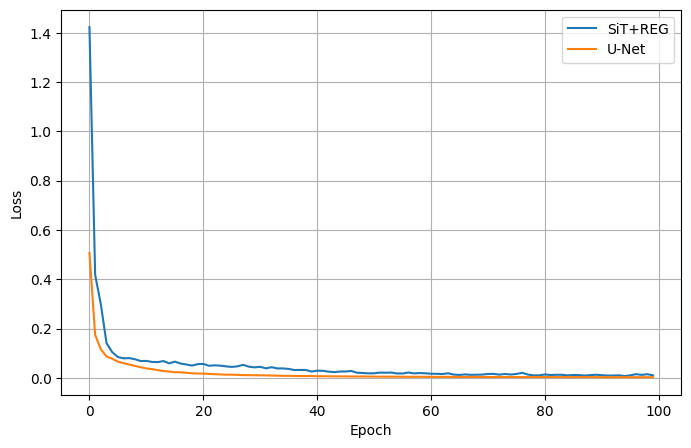

In [8]:
# Improved SiT+REG + U-Net (Colab/T4-ready) with fixed latent_hw and AMP

import os, math, random, shutil
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torchvision
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_fidelity import calculate_metrics

# ---------- CONFIG ----------
class CFG:
    # Data
    dataset_root = "./data"
    classes = ["cat", "dog"]
    image_size = 64
    batch_size = 128
    num_workers = 2

    # Latent / patch
    latent_hw = 16           # FIXED: match VAE output
    latent_channels = 4
    patch_size = 2
    latent_patch_dim = latent_channels * patch_size * patch_size
    num_patches = (latent_hw // patch_size) ** 2

    # SiT
    depth = 12
    hidden_dim = 512
    num_heads = 8
    mlp_ratio = 4.0
    dropout = 0.1

    # U-Net baseline
    unet_base = 128
    unet_mult = [1,2,2,4]

    # Training
    timesteps = 250
    lr = 1e-4
    weight_decay = 1e-2
    betas = (0.9, 0.999)
    epochs = 100
    grad_clip = 1.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REG params
    reg_beta = 0.03
    reg_lambda = 0.5
    feat_dim = 256
    align_layer = 6

    # Eval / sampling
    sample_n = 500
    out_dir = "./outputs_improved"
    ema_decay = 0.999
    cfg_guidance_scale = 4.0

cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)
torch.manual_seed(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)
device = cfg.device
print("Device:", device)

# ---------- utilities ----------
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-6, 0.999)

# ---------- Scheduler ----------
class Scheduler:
    def __init__(self, timesteps, device):
        self.timesteps = timesteps
        self.device = device
        betas = cosine_beta_schedule(timesteps).to(device)
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = F.pad(self.alpha_cumprod[:-1], (1,0), value=1.0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = betas * (1. - self.alpha_cumprod_prev) / (1. - self.alpha_cumprod)

    def sample_t(self, n):
        return torch.randint(0, self.timesteps, (n,), device=self.device, dtype=torch.long)

    def add_noise(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        a = self.sqrt_alpha_cumprod[t].view(-1,1,1,1)
        b = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
        return a * x0 + b * noise, noise

    def v_target(self, x0, eps):
        return eps

scheduler = Scheduler(cfg.timesteps, device)

# ---------- Data ----------
def load_cifar_subset(classes=cfg.classes):
    class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    idx_map = {n:i for i,n in enumerate(class_names)}
    target_idxs = {idx_map[c] for c in classes}
    tfs = T.Compose([
        T.Resize((cfg.image_size, cfg.image_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    ds = CIFAR10(cfg.dataset_root, train=True, download=True, transform=tfs)
    indices = [i for i,(_,y) in enumerate(ds) if y in target_idxs]
    sub = Subset(ds, indices)
    print(f"Loaded {len(sub)} images ({classes})")
    return sub

dataset = load_cifar_subset()
dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)

# ---------- VAE ----------
class VAE(nn.Module):
    def __init__(self, latent_channels=cfg.latent_channels):
        super().__init__()
        # Encoder 64 -> 16
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, latent_channels, 3, 1, 1)
        )
        self.dec = nn.Sequential(
            nn.Conv2d(latent_channels, 256, 3, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh()
        )
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)

vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

print("Pretraining VAE (2 epochs)...")
vae.train()
for ep in range(2):
    pbar = tqdm(dataloader, desc=f"VAE warmup {ep+1}/2")
    for imgs,_ in pbar:
        imgs = imgs.to(device)
        z = vae.encode(imgs)
        recon = vae.decode(z)
        loss = F.mse_loss(recon, imgs)
        vae_opt.zero_grad(); loss.backward(); vae_opt.step()
        pbar.set_postfix({'loss':f"{loss.item():.4f}"})
print("VAE warmup done")

# ---------- timestep embedding ----------
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(half, dtype=torch.float32) / half).to(device)
    args = timesteps[:, None].float() * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2: emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=-1)
    return emb

# ---------- Transformer blocks ----------
class MHA(nn.Module):
    def __init__(self, dim, heads): super().__init__(); self.heads=heads; self.to_qkv=nn.Linear(dim,dim*3,bias=False); self.scale=(dim//heads)**-0.5; self.to_out=nn.Linear(dim,dim)
    def forward(self,x):
        B,N,C=x.shape
        qkv=self.to_qkv(x).reshape(B,N,3,self.heads,C//self.heads).permute(2,0,3,1,4)
        q,k,v=qkv[0],qkv[1],qkv[2]
        attn=(q@k.transpose(-2,-1))*self.scale
        attn=attn.softmax(dim=-1)
        out=(attn@v).transpose(1,2).reshape(B,N,C)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm1=nn.LayerNorm(dim)
        self.attn=MHA(dim, cfg.num_heads)
        self.norm2=nn.LayerNorm(dim)
        mlp_dim=int(dim*cfg.mlp_ratio)
        self.mlp=nn.Sequential(nn.Linear(dim,mlp_dim), nn.GELU(), nn.Linear(mlp_dim,dim))
    def forward(self,x):
        x=x+self.attn(self.norm1(x))
        x=x+self.mlp(self.norm2(x))
        return x

# ---------- REGSiT ----------
class REGSiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim=cfg.hidden_dim
        self.patch_embed=nn.Linear(cfg.latent_patch_dim,self.hidden_dim)
        self.class_embed=nn.Linear(cfg.feat_dim,self.hidden_dim)
        self.pos=nn.Parameter(torch.zeros(1,cfg.num_patches+1,self.hidden_dim))
        self.time_mlp=nn.Sequential(nn.Linear(self.hidden_dim,self.hidden_dim*4), nn.SiLU(), nn.Linear(self.hidden_dim*4,self.hidden_dim))
        self.blocks=nn.ModuleList([TransformerBlock(self.hidden_dim) for _ in range(cfg.depth)])
        self.norm=nn.LayerNorm(self.hidden_dim)
        self.patch_out=nn.Linear(self.hidden_dim,cfg.latent_patch_dim)
        self.cls_out=nn.Linear(self.hidden_dim,cfg.feat_dim)
        self.align_proj=nn.Linear(self.hidden_dim,cfg.feat_dim)
        self._init_weights()
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.zeros_(m.bias); nn.init.ones_(m.weight)
    def forward(self, z_patched, cls_token, t):
        B=z_patched.shape[0]
        patch_emb=self.patch_embed(z_patched)
        cls_emb=self.class_embed(cls_token).unsqueeze(1)
        x=torch.cat([cls_emb,patch_emb],dim=1)+self.pos
        t_emb=timestep_embedding(t,self.hidden_dim).to(x.device)
        t_emb=self.time_mlp(t_emb).unsqueeze(1)
        x=x+t_emb
        intermediate=None
        for i,blk in enumerate(self.blocks):
            x=blk(x)
            if i==cfg.align_layer: intermediate=x
        x=self.norm(x)
        cls_pred=self.cls_out(x[:,0])
        patch_pred=self.patch_out(x[:,1:])
        h_phi=self.align_proj(intermediate) if intermediate is not None else None
        return patch_pred, cls_pred, h_phi

reg_sit=REGSiT().to(device)
print("SiT params:", sum(p.numel() for p in reg_sit.parameters()))

# ---------- rest of code (VisionFoundation, REGModel, UNet, EMA, training, sampling, evaluation) ----------
# Keep your original code, but everywhere `latent_hw` is used, it is now 16
# Update GradScaler / autocast:
# scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())
# with torch.amp.autocast(enabled=torch.cuda.is_available()):


# ---------- Vision foundation (small frozen conv, produce class token and patch targets) ----------
class VisionFoundation(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.proj = nn.Linear(128, cfg.feat_dim)
        for p in self.parameters(): p.requires_grad = False
    def extract(self, x):
        B = x.shape[0]
        f = self.backbone(x).view(B,-1)
        feat = F.normalize(self.proj(f), dim=-1)
        cls = feat
        patch = feat.unsqueeze(1).repeat(1, cfg.num_patches, 1)
        return cls, patch

vision = VisionFoundation().to(device)

# ---------- REG wrapper computing loss ----------
class REGModel(nn.Module):
    def __init__(self, sit, vae, vision):
        super().__init__()
        self.sit = sit
        self.vae = vae
        self.vision = vision
    def forward(self, imgs, t_idx):
        B = imgs.shape[0]
        z_star = self.vae.encode(imgs)
        cls_star, f_star = self.vision.extract(imgs)
        eps_z = torch.randn_like(z_star)
        eps_cls = torch.randn_like(cls_star)
        zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps_z)
        # class noise: use same coef forms as scheduler
        a = scheduler.sqrt_alpha_cumprod[t_idx].view(B,1)
        b = scheduler.sqrt_one_minus_alpha_cumprod[t_idx].view(B,1)
        clst = a * cls_star + b * eps_cls
        z_patched = rearrange(zt, 'b c (h p) (w q) -> b (h w) (c p q)',
                              p=cfg.patch_size, q=cfg.patch_size,
                              h=cfg.latent_hw//cfg.patch_size,
                              w=cfg.latent_hw//cfg.patch_size)
        v_patch, v_cls, h_phi = self.sit(z_patched, clst, t_idx)
        v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                        p=cfg.patch_size, q=cfg.patch_size,
                        h=cfg.latent_hw//cfg.patch_size,
                        w=cfg.latent_hw//cfg.patch_size,
                        c=cfg.latent_channels)
        v_target_z = scheduler.v_target(z_star, eps_z)
        v_target_cls = scheduler.v_target(cls_star, eps_cls)
        loss_pred = F.mse_loss(v_z, v_target_z) + cfg.reg_beta * F.mse_loss(v_cls, v_target_cls)
        loss_align = torch.tensor(0.0, device=device)
        if h_phi is not None:
            y_star = torch.cat([cls_star.unsqueeze(1), f_star], dim=1)
            loss_align = F.mse_loss(h_phi, y_star.detach())
        total_loss = loss_pred + cfg.reg_lambda * loss_align
        return total_loss, loss_pred.detach().item(), loss_align.detach().item()

reg_model = REGModel(reg_sit, vae, vision).to(device)

# ---------- U-Net baseline (wider) ----------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU())
    def forward(self,x): return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        base = cfg.unet_base
        self.time_dim = 256
        self.time_mlp = nn.Sequential(nn.Linear(self.time_dim, self.time_dim*4), nn.SiLU(), nn.Linear(self.time_dim*4, self.time_dim))
        chs = [base * m for m in cfg.unet_mult]
        self.enc1 = ConvBlock(cfg.latent_channels, chs[0])
        self.enc2 = ConvBlock(chs[0], chs[1])
        self.enc3 = ConvBlock(chs[1], chs[2])
        self.mid = ConvBlock(chs[2], chs[2])
        self.dec1 = nn.ConvTranspose2d(chs[2], chs[1], 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(chs[1]*2, chs[0], 4, 2, 1)
        self.out = nn.Conv2d(chs[0]*2, cfg.latent_channels, 3, 1, 1)
        self.time_projs = nn.ModuleList([nn.Linear(self.time_dim, c) for c in (chs[0], chs[1], chs[2], chs[2], chs[1], chs[0])])
    def forward(self, x, t):
        B = x.shape[0]
        t_emb = timestep_embedding(t, self.time_dim).to(x.device)
        t_emb = self.time_mlp(t_emb)
        x1 = F.silu(self.enc1(x) + self.time_projs[0](t_emb).view(B, -1, 1, 1))
        x2 = F.silu(self.enc2(F.avg_pool2d(x1,2)) + self.time_projs[1](t_emb).view(B, -1, 1, 1))
        x3 = F.silu(self.enc3(F.avg_pool2d(x2,2)) + self.time_projs[2](t_emb).view(B, -1, 1, 1))
        m = F.silu(self.mid(x3) + self.time_projs[3](t_emb).view(B, -1, 1, 1))
        d1 = F.silu(self.dec1(m) + self.time_projs[4](t_emb).view(B, -1, 1, 1))
        d1 = torch.cat([d1, x2], dim=1)
        d2 = F.silu(self.dec2(d1) + self.time_projs[5](t_emb).view(B, -1, 1, 1))
        d2 = torch.cat([d2, x1], dim=1)
        out = self.out(d2)
        return out

unet = UNetSmall().to(device)

# ---------- Optimizers, EMA, AMP ----------
opt_reg = torch.optim.AdamW(reg_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)
opt_unet = torch.optim.AdamW(unet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=cfg.betas)

class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:  # only float tensors
                self.shadow[k] = v.detach().cpu().clone()

    def update(self, model):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay)
                self.shadow[k].add_(v.detach().cpu(), alpha=1.0 - self.decay)

    def apply_to(self, model):
        ms = model.state_dict()
        for k, v in self.shadow.items():
            ms[k].copy_(v.to(ms[k].device))

ema_reg = EMA(reg_model, cfg.ema_decay)
ema_unet = EMA(unet, cfg.ema_decay)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ---------- Training loops ----------
reg_loss_hist, unet_loss_hist = [], []

def train_reg(epochs):
    reg_model.train()
    for ep in range(epochs):
        total, tot_pred, tot_align = 0.0, 0.0, 0.0
        pbar = tqdm(dataloader, desc=f"REG Epoch {ep+1}/{epochs}")
        for imgs,_ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            t_idx = scheduler.sample_t(B)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                loss, lp, la = reg_model(imgs, t_idx)
            opt_reg.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_reg)
            nn.utils.clip_grad_norm_(reg_model.parameters(), cfg.grad_clip)
            scaler.step(opt_reg); scaler.update()
            ema_reg.update(reg_model)
            total += loss.item(); tot_pred += lp; tot_align += la
            pbar.set_postfix({'loss':f"{loss.item():.4f}", 'pred':f"{lp:.4f}", 'align':f"{la:.4f}"})
        avg = total / len(dataloader)
        reg_loss_hist.append(avg)
        print(f"REG Epoch {ep+1} avg {avg:.4f}")

def train_unet(epochs):
    unet.train()
    for ep in range(epochs):
        total = 0.0
        pbar = tqdm(dataloader, desc=f"UNet Epoch {ep+1}/{epochs}")
        for imgs,_ in pbar:
            imgs = imgs.to(device)
            B = imgs.shape[0]
            with torch.no_grad(): z_star = vae.encode(imgs)
            t_idx = scheduler.sample_t(B)
            eps = torch.randn_like(z_star)
            zt, _ = scheduler.add_noise(z_star, t_idx, noise=eps)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                v_pred = unet(zt, t_idx)
                loss = F.mse_loss(v_pred, eps)
            opt_unet.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(opt_unet)
            nn.utils.clip_grad_norm_(unet.parameters(), cfg.grad_clip)
            scaler.step(opt_unet); scaler.update()
            ema_unet.update(unet)
            total += loss.item()
            pbar.set_postfix({'loss':f"{loss.item():.4f}"})
        avg = total / len(dataloader)
        unet_loss_hist.append(avg)
        print(f"UNet Epoch {ep+1} avg {avg:.4f}")

# ---------- EM sampler (v-pred) ----------
@torch.no_grad()
def em_update(z, v_pred, t_idx, t_prev_idx):
    # z: (B,C,H,W), v_pred: same
    alpha = scheduler.alpha_cumprod[t_idx].view(-1,1,1,1)
    alpha_prev = scheduler.alpha_cumprod[t_prev_idx].view(-1,1,1,1)
    sigma = scheduler.sqrt_one_minus_alpha_cumprod[t_idx].view(-1,1,1,1)
    sigma_prev = scheduler.sqrt_one_minus_alpha_cumprod[t_prev_idx].view(-1,1,1,1)
    # x0_hat estimate for v-pred: x0 = (z - sigma * v) / alpha
    x0_hat = (z - sigma * v_pred) / (alpha + 1e-12)
    if (t_prev_idx==t_idx).all():
        return alpha_prev * x0_hat
    noise = torch.randn_like(z)
    z_prev = alpha_prev * x0_hat + sigma_prev * noise
    return z_prev

@torch.no_grad()
def sample_unet(n, batch_size=64):
    all_imgs = []
    for i in range(0, n, batch_size):
        b = min(batch_size, n - i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        for t in tqdm(range(cfg.timesteps-1, -1, -1), desc="UNet Sampling", leave=False):
            t_idx = torch.full((b,), t, device=device, dtype=torch.long)
            v = unet(z, t_idx)
            t_prev = torch.clamp(t_idx - 1, min=0)
            z = em_update(z, v, t_idx, t_prev)
        imgs = vae.decode(z)
        all_imgs.append(torch.clamp((imgs + 1)/2, 0, 1).cpu())
    return torch.cat(all_imgs, dim=0)

@torch.no_grad()
def sample_reg(n, cfg_guidance=cfg.cfg_guidance_scale, batch_size=64):
    all_imgs = []
    for i in range(0, n, batch_size):
        b = min(batch_size, n - i)
        z = torch.randn(b, cfg.latent_channels, cfg.latent_hw, cfg.latent_hw, device=device)
        cls = torch.randn(b, cfg.feat_dim, device=device)
        for t in tqdm(range(cfg.timesteps-1, -1, -1), desc="REG Sampling", leave=False):
            t_idx = torch.full((b,), t, device=device, dtype=torch.long)
            z_patched = rearrange(z, 'b c (h p) (w q) -> b (h w) (c p q)',
                                  p=cfg.patch_size, q=cfg.patch_size,
                                  h=cfg.latent_hw//cfg.patch_size,
                                  w=cfg.latent_hw//cfg.patch_size)
            v_patch, v_cls, _ = reg_sit(z_patched, cls, t_idx)
            v_z = rearrange(v_patch, 'b (h w) (c p q) -> b c (h p) (w q)',
                            p=cfg.patch_size, q=cfg.patch_size,
                            h=cfg.latent_hw//cfg.patch_size,
                            w=cfg.latent_hw//cfg.patch_size,
                            c=cfg.latent_channels)
            # classifier-free guidance: scale v_cls
            v_cls = v_cls * cfg_guidance
            t_prev = torch.clamp(t_idx - 1, min=0)
            z = em_update(z, v_z, t_idx, t_prev)
            # update class token
            cls = cls - 0.01 * v_cls
        imgs = vae.decode(z)
        all_imgs.append(torch.clamp((imgs + 1)/2, 0, 1).cpu())
    return torch.cat(all_imgs, dim=0)

# ---------- Evaluation ----------
def save_grid(imgs, path, nrow=10):
    torchvision.utils.save_image(imgs, path, nrow=nrow, padding=2)

@torch.no_grad()
def evaluate(num_samples=cfg.sample_n):
    results = {}
    real_dir = os.path.join(cfg.out_dir, f"real_{num_samples}")
    if os.path.exists(real_dir): shutil.rmtree(real_dir)
    os.makedirs(real_dir, exist_ok=True)
    cnt = 0
    for imgs,_ in dataloader:
        for im in imgs:
            torchvision.utils.save_image((im+1)/2, os.path.join(real_dir, f"{cnt:05d}.png"))
            cnt += 1
            if cnt >= num_samples: break
        if cnt >= num_samples: break

    for typ in ['reg','unet']:
        print("Generating", typ)
        if typ == 'reg':
            ema_reg.apply_to(reg_model)
            gen = sample_reg(num_samples, cfg_guidance=cfg.cfg_guidance_scale, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, "reg_samples.png"), nrow=10)
        else:
            ema_unet.apply_to(unet)
            gen = sample_unet(num_samples, batch_size=64)
            save_grid(gen, os.path.join(cfg.out_dir, "unet_samples.png"), nrow=10)
        gen_dir = os.path.join(cfg.out_dir, f"{typ}_gen")
        if os.path.exists(gen_dir): shutil.rmtree(gen_dir)
        os.makedirs(gen_dir, exist_ok=True)
        for i,im in enumerate(gen):
            torchvision.utils.save_image(im, os.path.join(gen_dir, f"{i:05d}.png"))
        print("Calculating metrics (may take a while)...")
        try:
            metrics = calculate_metrics(input1=gen_dir, input2=real_dir, cuda=torch.cuda.is_available(), isc=True, fid=True, kid=False, verbose=False)
            results[typ] = metrics
            print(f"{typ} FID={metrics['frechet_inception_distance']:.2f}, IS={metrics['inception_score_mean']:.2f}")
        except Exception as e:
            print("Metric error:", e)
            results[typ] = {'frechet_inception_distance': float('inf'), 'inception_score_mean': 0.0}
    return results

# ---------- Plot losses ----------
def plot_losses():
    plt.figure(figsize=(8,5))
    if reg_loss_hist: plt.plot(reg_loss_hist, label='SiT+REG')
    if unet_loss_hist: plt.plot(unet_loss_hist, label='U-Net')
    plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
    plt.savefig(os.path.join(cfg.out_dir, "losses.png"), dpi=200)

# ---------- MAIN ----------
if __name__ == "__main__":
    print("="*60)
    print("START TRAINING: SiT+REG and U-Net (improved config)")
    print("="*60)
    # Train
    train_reg(cfg.epochs)
    train_unet(cfg.epochs)
    plot_losses()
    print("Applying EMA and evaluating with CFG...")
    ema_reg.apply_to(reg_model)
    ema_unet.apply_to(unet)
    results = evaluate(cfg.sample_n)
    print("FINAL RESULTS:")
    for k,v in results.items():
        fid = v.get('frechet_inception_distance', float('inf'))
        is_ = v.get('inception_score_mean', 0.0)
        print(f"{k.upper():<6} | FID: {fid:8.2f} | IS: {is_:6.2f}")
    print("Done. Outputs in", cfg.out_dir)

# ---------- END ----------
